In [3]:
import pandas as pd
from typing import Tuple
from datetime import timedelta
import matplotlib
matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import os
import matplotlib.patches as mpatches
from extra_plotting import *
from typing import Tuple
import pandas as pd


In [4]:
if __name__ == '__main__':
    data_path = '/home/cate/Downloads/codes_marc/data/global_trials1.csv'
    df = pd.read_csv(data_path, sep=';', low_memory=False, dtype={'iti_duration': float})
    # 1 for analisis of trained mice, 0 for untrained
    #print(df['task'].unique())
    df['task'].isin(['S4_5'])
    exclude_subjects = ['A10', 'R1', 'R2']
    df = df[~df['subject'].isin(exclude_subjects)].copy()

    df['left_poke_in'] = df['Port2In_START']
    df['left_poke_out'] = df['Port2Out_START']

    df['center_poke_in'] =  df['Port3In_START']
    df['center_poke_out'] = df['Port3Out_START']

    df['right_poke_in'] =  df['Port5In_START']
    df['right_poke_out'] = df['Port5Out_START']

    df['right_poke_in'] = df['right_poke_in'].astype(str)
    df['left_poke_in'] = df['left_poke_in'].astype(str)

    df['first_response_right'] = (
        df['right_poke_in']
        .fillna('')  # sostituisce i NaN con stringa vuota
        .astype(str)
        .str.split(',')
        .str[0]
        .replace('', np.nan)  # se la prima voce è vuota, metti NaN
        .astype(float)
    )

    df['first_response_left'] = (
        df['left_poke_in']
        .fillna('')
        .astype(str)
        .str.split(',')
        .str[0]
        .replace('', np.nan)
        .astype(float)
    )
    
left = df['first_response_left'].fillna(9999)
right = df['first_response_right'].fillna(9999)

conditions = [
    (left == 9999) & (right == 9999),  # nessuna risposta
    (left == 9999),                    # solo right
    (right == 9999),                   # solo left
    (left <= right),                  # left più veloce
    (left > right),                   # right più veloce
]

responses = ["no_response", "right", "left", "left", "right"]

df["first_trial_response"] = np.select(conditions, responses, default="no_response")



df['fraction_of_correct_responses'] = np.where(
    ((df['probability_r'] >= 0.5) & (df['first_trial_response'] == "right")) |
    ((df['probability_r'] < 0.5) & (df['first_trial_response'] == "left")),
    1, 0
)


    # df['prev_iti_duration'] = df.groupby('session')['iti_duration'].shift()
    # #new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition
    # #new_df = df[df['prev_iti_duration'] > 0.5]
    # df['prev_opto_bool'] = df.groupby('session')['opto_bool'].shift()
    # trained = 1
    # automated = 0
    # new_df = parsing(df,trained,1,automated,0)
    # print(new_df)
    #new_df = df
    #glm(new_df)

In [5]:
df[['outcome', 'fraction_of_correct_responses']]


outcome  fraction_of_correct_responses
12            NaN                              0
13            NaN                              0
14            NaN                              0
15            NaN                              0
16            NaN                              0
...           ...                            ...
877474  incorrect                              1
877475  incorrect                              1
877476    correct                              1
877477    correct                              1
877478    correct                              1

[877467 rows x 2 columns]

In [6]:
# def parse_sessions(df, training_sessions, target_session):
#     """
#     Estrae training e target session dai dati completi.

#     Args:
#         df (pd.DataFrame): Dataframe originale con colonna 'session'.
#         training_sessions (list[int]): lista di sessioni da usare per il training.
#         target_session (int): sessione specifica target.

#     Returns:
#         df_train (pd.DataFrame), df_target (pd.DataFrame)
#     """
#     df['task'].isin(['S4_5'])
#     df_train = df[df['session'].isin(training_sessions)].reset_index(drop=True)
#     df_target = df[df['session'] == target_session].reset_index(drop=True)

#     return df_train, df_target


In [7]:
def obt_regressors(df: pd.DataFrame, n: int) -> Tuple[pd.DataFrame, str]:
    """
    Summary:
    This function processes the data needed to obtain the regressors and derives the 
    formula for the glm

    Args:
        df ([Dataframe]): [dataframe with experimental data]
        n ([int]): [number of trials back considered]

    Returns:
        new_df([Dataframe]): [dataframe with processed data restricted to the regression]
        regressors_string([string]) :  [regression formula]
    """
    # Select the columns needed for the regressors
    new_df = df[['session', 'subject','trial', 'task', 'outcome', 'side', 'fraction_of_correct_responses','iti_duration', 'probability_r']].copy()
    new_df['outcome_bool'] = np.where(new_df['outcome'] == "correct", 1, 0)
    
    # Keep only sessions with more than 50 trials
    session_counts = new_df['session'].value_counts()
    mask = new_df['session'].isin(session_counts[session_counts > 50].index)
    new_df = new_df[mask]
    
    # Define choice column based on outcome and side
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['side'] == 'right'), 'choice'] = 'left'
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['side'] == 'left'), 'choice'] = 'left'
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['side'] == 'left'), 'choice'] = 'right'
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['side'] == 'right'), 'choice'] = 'right'
    new_df['choice'].fillna('other', inplace=True)
    
    # Define r_plus and r_minus
    new_df.loc[new_df['outcome_bool'] == 0, 'r_plus'] = 0
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['choice'] == 'left'), 'r_plus'] = -1
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['choice'] == 'right'), 'r_plus'] = 1
    new_df['r_plus'] = pd.to_numeric(new_df['r_plus'].fillna(0), errors='coerce')
    
    new_df.loc[new_df['outcome_bool'] == 1, 'r_minus'] = 0
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['choice'] == 'left'), 'r_minus'] = -1
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['choice'] == 'right'), 'r_minus'] = 1
    new_df['r_minus'] = pd.to_numeric(new_df['r_minus'].fillna(0), errors='coerce')
    
    # Prepare switch regressor
    new_df['choice_1'] = new_df.groupby('session')['choice'].shift(1)
    new_df.loc[(new_df['choice'] == new_df['choice_1']), 'switch_num'] = 0
    new_df.loc[(new_df['choice'] != new_df['choice_1']), 'switch_num'] = 1
    
    # Add previous outcome as a regressor
    new_df['outcome_bool_1'] = new_df.groupby('session')['outcome_bool'].shift(1)
    
    # Build regressors for previous trials
    rss_plus = ''
    rss_minus = ''
    rds_plus = ''

    for i in range(2, n + 1):
        new_df[f'outcome_bool_{i}'] = new_df.groupby('session')['outcome_bool'].shift(i)

        new_df[f'choice_{i}'] = new_df.groupby('session')['choice'].shift(i)

        new_df[f'rss_plus{i}'] = 0
        new_df[f'rss_minus{i}'] = 0
        new_df[f'rds_plus{i}'] = 0
            
        # Compute regressors based on the corrected definition
        new_df.loc[(new_df[f'choice_{i}'] == new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 1), f'rss_plus{i}'] = 1
        new_df.loc[(new_df[f'choice_{i}'] == new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 0), f'rss_minus{i}'] = 1
        new_df.loc[(new_df[f'choice_{i}'] != new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 1), f'rds_plus{i}'] = 1
        
       
        #new_df.loc[(new_df[f'choice_{i}'] != new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 0), f'rds_minus{i}'] = 1
    
    # Ensure NaNs are converted to 0
        for reg in [f'rss_plus{i}', f'rss_minus{i}', f'rds_plus{i}']:
            new_df[reg] = pd.to_numeric(new_df[reg], errors='coerce')
    
        rss_plus += f'rss_plus{i} + '
        rss_minus += f'rss_minus{i} + '
        rds_plus += f'rds_plus{i} + '

    regressors_string = rss_plus + rss_minus + rds_plus + 'outcome_bool_1'
    
    # Display selected columns
    columns_to_display = ['trial', 'choice', 'outcome_bool', 'outcome_bool_1'] + [f'rss_plus{i}' for i in range(2, n + 1)] + [f'rss_minus{i}' for i in range(2, n + 1)] \
        + [f'rds_plus{i}' for i in range(2, n + 1)]
    print(new_df[columns_to_display].head(10))
    print(new_df)
    return new_df, regressors_string

new_df, regressors_string = obt_regressors(df, 10)
new_df 


/tmp/ipykernel_16197/1105256217.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['choice'].fillna('other', inplace=True)


    trial choice  outcome_bool  outcome_bool_1  rss_plus2  rss_plus3  \
12      1   left             0             NaN          0          0   
13      2   left             0             0.0          0          0   
14      3   left             0             0.0          0          0   
15      4   left             0             0.0          0          0   
16      5   left             0             0.0          0          0   
17      6   left             0             0.0          0          0   
18      7   left             0             0.0          0          0   
19      8   left             0             0.0          0          0   
20      9   left             0             0.0          0          0   
21     10   left             0             0.0          0          0   

    rss_plus4  rss_plus5  rss_plus6  rss_plus7  ...  rss_minus10  rds_plus2  \
12          0          0          0          0  ...            0          0   
13          0          0          0          0  .

session subject  trial                  task    outcome   side  \
12            1      B1      1                    S1        NaN  right   
13            1      B1      2                    S1        NaN  right   
14            1      B1      3                    S1        NaN  right   
15            1      B1      4                    S1        NaN  right   
16            1      B1      5                    S1        NaN  right   
...         ...     ...    ...                   ...        ...    ...   
877474      441      B9    511  S4_5_third_condition  incorrect  right   
877475      441      B9    512  S4_5_third_condition  incorrect  right   
877476      441      B9    513  S4_5_third_condition    correct   left   
877477      441      B9    514  S4_5_third_condition    correct   left   
877478      441      B9    515  S4_5_third_condition    correct   left   

        fraction_of_correct_responses  iti_duration  probability_r  \
12                                  0           NaN            NaN   
13                                  0           NaN            NaN   
14                                  0           NaN            NaN   
15                                  0           NaN            NaN   
16                                  0           NaN            NaN   
...                               ...           ...            ...   
877474                              1      0.682407            0.1   
877475                              1     13.585942            0.1   
877476                              1      4.686696            0.1   
877477                              1      3.899575            0.1   
877478                              1     19.599884            0.1   

        outcome_bool  ... outcome_bool_9  choice_9  rss_plus9 rss_minus9  \
12                 0  ...            NaN       NaN          0          0   
13                 0  ...            NaN       NaN          0          0   
14                 0  ...            NaN       NaN          0          0   
15                 0  ...            NaN       NaN          0          0   
16                 0  ...            NaN       NaN          0          0   
...              ...  ...            ...       ...        ...        ...   
877474             0  ...            1.0      left          1          0   
877475             0  ...            1.0      left          1          0   
877476             1  ...            1.0      left          1          0   
877477             1  ...            1.0      left          1          0   
877478             1  ...            1.0      left          1          0   

        rds_plus9  outcome_bool_10  choice_10 rss_plus10  rss_minus10  \
12              0              NaN        NaN          0            0   
13              0              NaN        NaN          0            0   
14              0              NaN        NaN          0            0   
15              0              NaN        NaN          0            0   
16              0              NaN        NaN          0            0   
...           ...              ...        ...        ...          ...   
877474          0              1.0       left          1            0   
877475          0              1.0       left          1            0   
877476          0              1.0       left          1            0   
877477          0              1.0       left          1            0   
877478          0              1.0       left          1            0   

        rds_plus10  
12               0  
13               0  
14               0  
15               0  
16               0  
...            ...  
877474           0  
877475           0  
877476           0  
877477           0  
877478           0  

[877467 rows x 61 columns]

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_switch_indices(df):
    # Trova gli switch come cambiamenti in switch_num
    return df.index[df['switch_num'] == 1]

def extract_outcome_windows(df, window=5):
    """
    Estrae outcome nei trial attorno allo switch (da -window a +window)
    """
    switch_idx = get_switch_indices(df)
    aligned_outcomes = []

    for idx in switch_idx:
        if idx - window < 0 or idx + window >= len(df):
            continue  

        window_data = df.iloc[idx - window : idx + window + 1].copy()
        lags = np.arange(-window, window + 1)
        outcomes = window_data['outcome_bool'].values

        for lag, outcome in zip(lags, outcomes):
            aligned_outcomes.append({
                'lag': lag,
                'outcome_bool': outcome
            })

    return pd.DataFrame(aligned_outcomes)

def plot_switch_triggered_average(aligned_df):
    mean_outcomes = aligned_df.groupby('lag')['outcome_bool'].mean()
    sem_outcomes = aligned_df.groupby('lag')['outcome_bool'].sem()

    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_outcomes.index, mean_outcomes.values, yerr=sem_outcomes.values,
                 fmt='o-', capsize=3, label='Mean outcome around switch')

    plt.axvline(0, color='black', linestyle='--', label='Switch')
    plt.axhline(0.5, color='gray', linestyle='--', label='Chance')
    plt.title('Switch-Triggered Average of Outcome')
    plt.xlabel('Trial relative to switch (lag)')
    plt.ylabel('Mean Outcome')
    plt.legend()
    plt.show()

# --------- Usage ---------

aligned_df = extract_outcome_windows(new_df, window=10)
plot_switch_triggered_average(aligned_df)


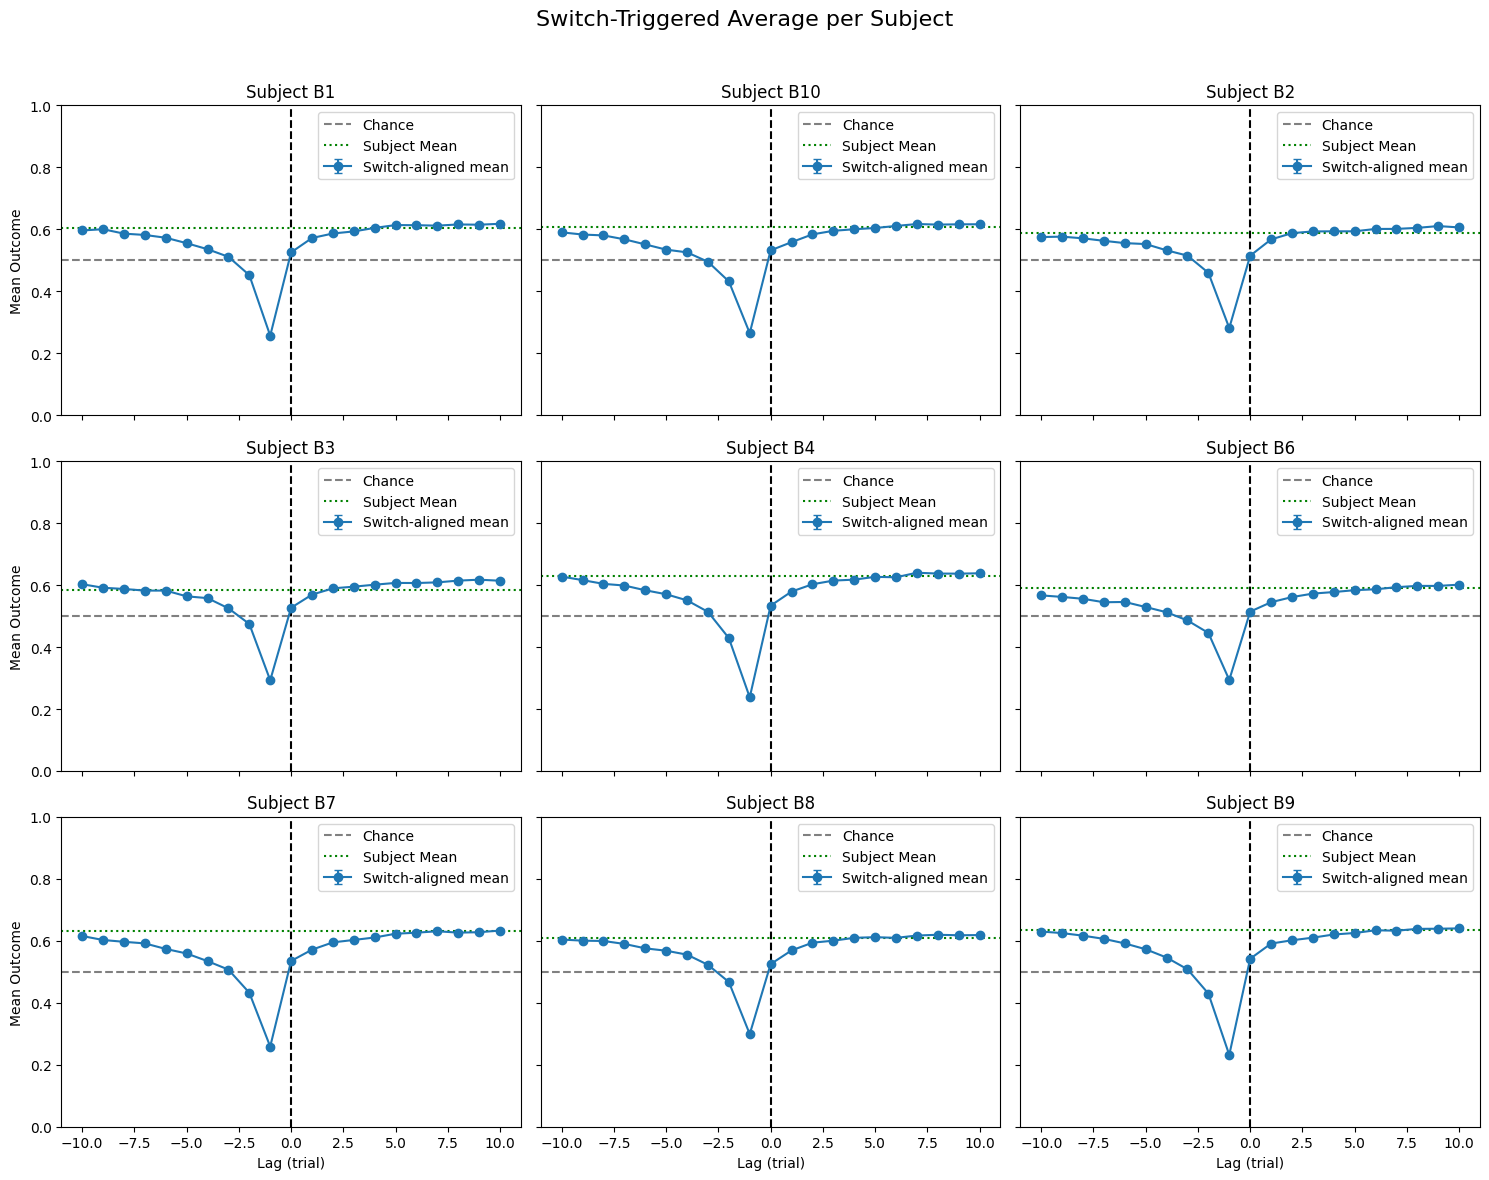

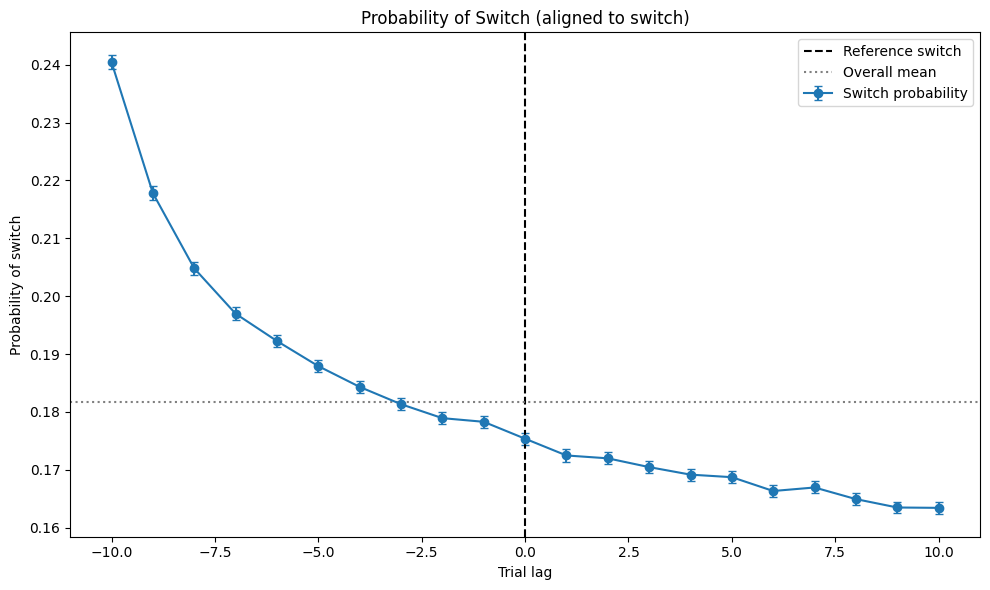

In [9]:
%matplotlib inline

def extract_outcome_windows_per_subject(df, window=5):
    """
    Estrae outcome attorno agli switch per ciascun soggetto
    """
    all_aligned = []

    for subj in df['subject'].unique():
        subj_df = df[df['subject'] == subj].reset_index(drop=True)
        aligned = extract_outcome_windows(subj_df, window)
        aligned['subject'] = subj
        all_aligned.append(aligned)

    return pd.concat(all_aligned, ignore_index=True)

def extract_switch_prob_windows(df, window=10):
    switch_idx = get_switch_indices(df)
    aligned_switches = []

    for idx in switch_idx:
        if idx - window < 0 or idx + window >= len(df):
            continue

        window_data = df.iloc[idx - window:idx + window + 1].copy()
        lags = np.arange(-window, window + 1)
        switches = window_data['switch_num'].values  # 1 o 0

        for lag, switch in zip(lags, switches):
            aligned_switches.append({
                'lag': lag,
                'switch': switch
            })

    return pd.DataFrame(aligned_switches)

def plot_switch_probability(aligned_df):
    prob = aligned_df.groupby('lag')['switch'].mean()
    sem = aligned_df.groupby('lag')['switch'].sem()

    plt.figure(figsize=(10, 6))
    plt.errorbar(prob.index, prob.values, yerr=sem.values,
                 fmt='o-', capsize=3, label='Switch probability')

    plt.axvline(0, linestyle='--', color='black', label='Reference switch')
    plt.axhline(prob.mean(), linestyle=':', color='gray', label='Overall mean')
    plt.title('Probability of Switch (aligned to switch)')
    plt.xlabel('Trial lag')
    plt.ylabel('Probability of switch')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_switch_triggered_grid(aligned_df, full_df):
    subjects = sorted(aligned_df['subject'].unique())[:9]
    n_subjects = len(subjects)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        data = aligned_df[aligned_df['subject'] == subj]
        
        # ✅ Calcola media outcome su TUTTO il dataset per quel soggetto
        subject_mean = new_df[new_df['subject'] == subj]['outcome_bool'].mean()

        # Media e sem attorno allo switch
        mean_outcomes = data.groupby('lag')['outcome_bool'].mean()
        sem_outcomes = data.groupby('lag')['outcome_bool'].sem()

        ax.errorbar(mean_outcomes.index, mean_outcomes.values, yerr=sem_outcomes.values,
                    fmt='o-', capsize=3, label='Switch-aligned mean')

        # Linee di riferimento
        ax.axvline(0, color='black', linestyle='--')
        ax.axhline(0.5, color='gray', linestyle='--', label='Chance')
        ax.axhline(subject_mean, color='green', linestyle=':', label='Subject Mean')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        if i % 3 == 0:
            ax.set_ylabel('Mean Outcome')
        if i >= 6:
            ax.set_xlabel('Lag (trial)')

        ax.legend()

    for j in range(n_subjects, 9):
        fig.delaxes(axs[j])

    plt.suptitle('Switch-Triggered Average per Subject', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --------- Usage ---------
aligned_df_all = extract_outcome_windows_per_subject(new_df, window=10)
plot_switch_triggered_grid(aligned_df_all, full_df=new_df)
aligned_switch_df = extract_switch_prob_windows(new_df, window=10)
plot_switch_probability(aligned_switch_df)


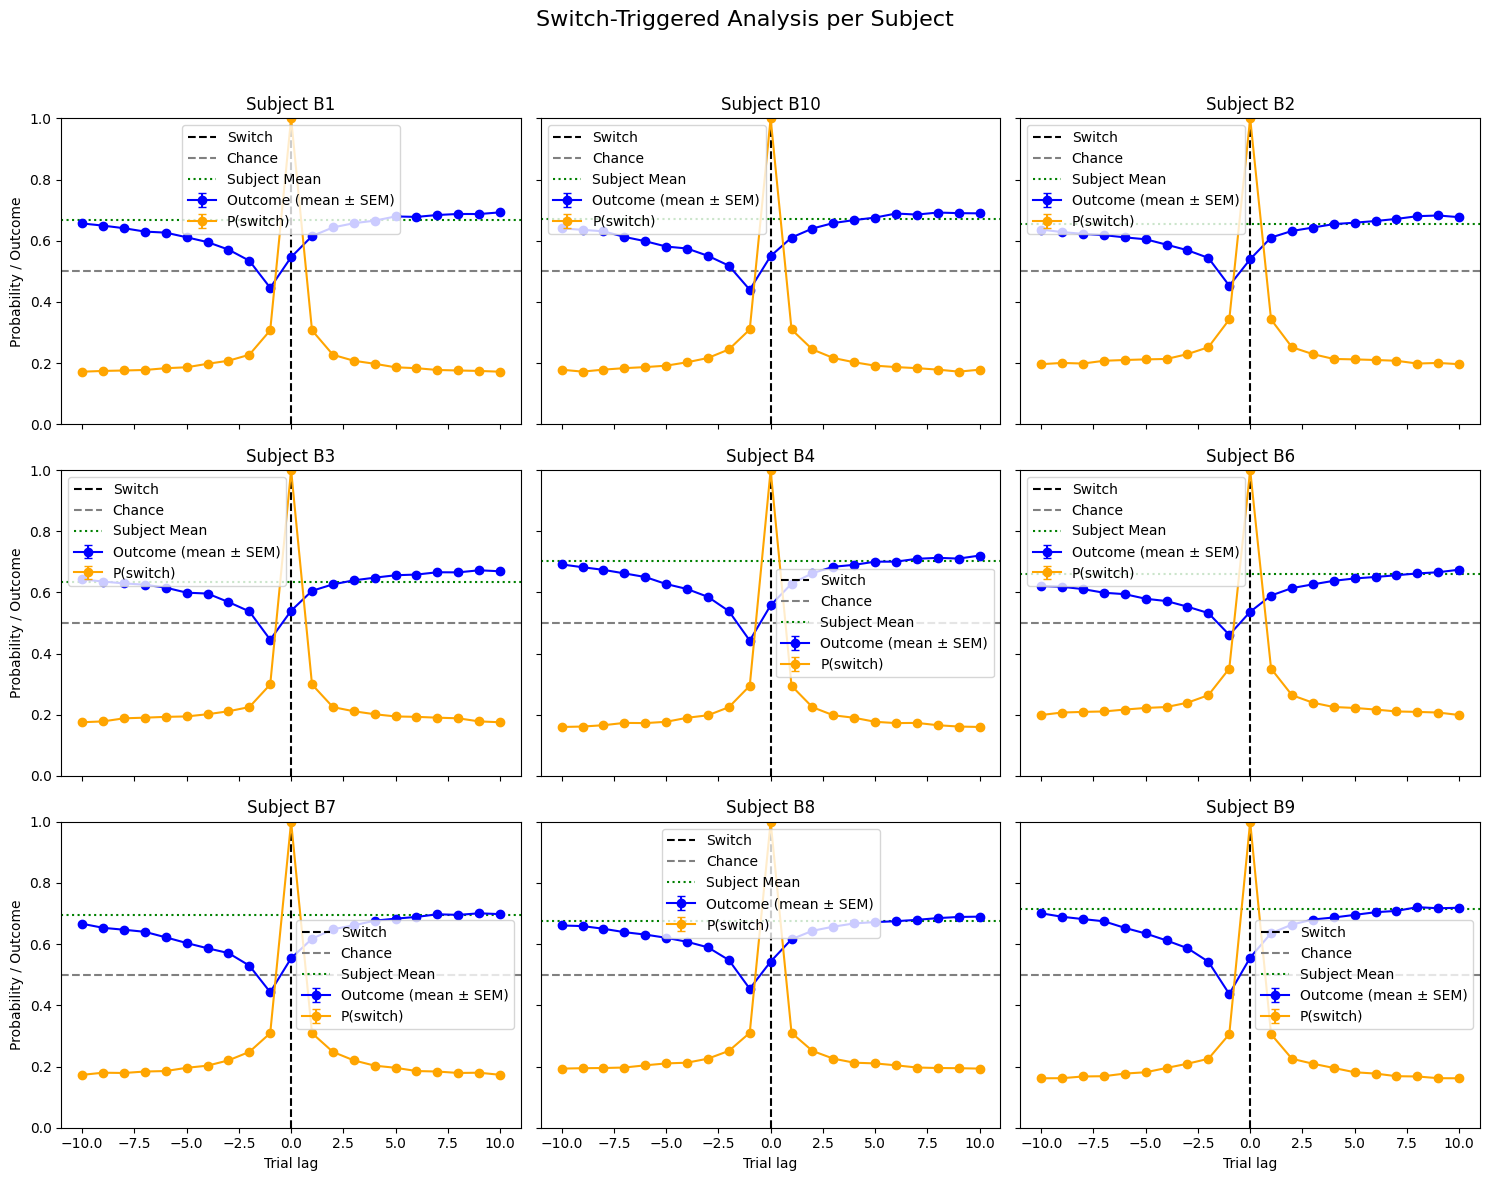

In [ ]:

def plot_combined_switch_analysis(df, window=10, max_subjects=9):
    subjects = sorted(df['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_df = df[df['subject'] == subj].reset_index(drop=True)

        # ----- Switch indices -----
        switch_idx = get_switch_indices(subj_df)

        # ----- Media outcome complessiva -----
        subject_mean = subj_df['fraction_of_correct_responses'].mean()


        # ----- Switch-triggered outcome -----
        aligned_outcome = []
        aligned_switches = []

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                aligned_outcome.append({'lag': lag, 'fraction_of_correct_responses': o})
                aligned_switches.append({'lag': lag, 'switch': s})

        # --- DF per outcome e switch ---
        outcome_df = pd.DataFrame(aligned_outcome)
        switch_df = pd.DataFrame(aligned_switches)

        # --- Plot outcome curve ---
        outcome_mean = outcome_df.groupby('lag')['fraction_of_correct_responses'].mean()
        outcome_sem = outcome_df.groupby('lag')['fraction_of_correct_responses'].sem()
        ax.errorbar(outcome_mean.index, outcome_mean.values, yerr=outcome_sem.values,
                    fmt='o-', capsize=3, label='Outcome (mean ± SEM)', color='blue')

        # --- Plot switch probability ---
        switch_prob = switch_df.groupby('lag')['switch'].mean()
        switch_sem = switch_df.groupby('lag')['switch'].sem()
        ax.errorbar(switch_prob.index, switch_prob.values, yerr=switch_sem.values,
                    fmt='o-', capsize=3, label='P(switch)', color='orange')

        # --- Linee di riferimento ---
        ax.axvline(0, linestyle='--', color='black', label='Switch')
        ax.axhline(0.5, linestyle='--', color='gray', label='Chance')
        ax.axhline(subject_mean, linestyle=':', color='green', label='Subject Mean')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        if i % ncols == 0:
            ax.set_ylabel('Probability / Outcome')
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel('Trial lag')
        ax.legend()

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])  # Rimuove subplot vuoti

    plt.suptitle('Switch-Triggered Analysis per Subject', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_combined_switch_analysis(new_df, window=10)



In [11]:
def plot_group_switch_analysis(df, window=10):
    subjects = df['subject'].unique()
    all_outcome = []
    all_switch = []
    all_subject_means = []

    for subj in subjects:
        subj_df = df[df['subject'] == subj].reset_index(drop=True)
        if subj_df.empty:
            continue

        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        all_subject_means.append(subject_mean)

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                all_outcome.append({'lag': lag, 'outcome_bool': o})
                all_switch.append({'lag': lag, 'switch': s})

    # --- Crea i DataFrame aggregati ---
    outcome_df = pd.DataFrame(all_outcome)
    switch_df = pd.DataFrame(all_switch)

    # --- Calcola medie e SEM ---
    outcome_mean = outcome_df.groupby('lag')['fraction_of_correct_responses'].mean()
    outcome_sem = outcome_df.groupby('lag')['fraction_of_correct_responses'].sem()

    switch_prob = switch_df.groupby('lag')['switch'].mean()
    switch_sem = switch_df.groupby('lag')['switch'].sem()

    group_mean = np.mean(all_subject_means)

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.errorbar(outcome_mean.index, outcome_mean.values, yerr=outcome_sem.values,
                 fmt='o-', capsize=3, label='Outcome (mean ± SEM)', color='blue')
    plt.errorbar(switch_prob.index, switch_prob.values, yerr=switch_sem.values,
                 fmt='o-', capsize=3, label='P(switch)', color='orange')

    plt.axvline(0, linestyle='--', color='black', label='Switch')
    plt.axhline(0.5, linestyle='--', color='gray', label='Chance')
    plt.axhline(group_mean, linestyle=':', color='green', label='Group Mean Perf.')

    plt.title('Group-Level Switch-Triggered Analysis')
    plt.xlabel('Trial lag')
    plt.ylabel('Probability / Outcome')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_group_switch_analysis(new_df, window=10)


KeyError: 'Column not found: fraction_of_correct_responses'

In [12]:
if __name__ == '__main__':
    data_path = '/home/cate/Downloads/codes_marc/data/clean_opto_light_on.csv'
    df1 = pd.read_csv(data_path, sep=',', low_memory=False, dtype={'iti_duration': float})
    # 1 for analisis of trained mice, 0 for untrained
    #print(df['task'].unique())
    exclude_subjects = ['A10', 'R1', 'R2']
    df1 = df1[~df1['subject'].isin(exclude_subjects)].copy()
    # df['prev_iti_duration'] = df.groupby('session')['iti_duration'].shift()
    # #new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition
    # #new_df = df[df['prev_iti_duration'] > 0.5]
    df1['prev_opto_bool'] = df1.groupby('session')['opto_bool'].shift()
    # trained = 1
    # automated = 0
    # new_df = parsing(df,trained,1,automated,0)
    # print(new_df)
    #new_df = df
    #glm(new_df)


    df1['left_poke_in'] = np.where(df1['box'] == 9, df1['Port2In_START'], df1['Port7In_START'])
    df1['left_poke_out'] = np.where(df1['box'] == 9, df1['Port2Out_START'], df1['Port7Out_START'])

    df1['center_poke_in'] = np.where(df1['box'] == 9, df1['Port3In_START'], df1['Port4In_START'])
    df1['center_poke_out'] = np.where(df1['box'] == 9, df1['Port3Out_START'], df1['Port4Out_START'])

    df1['right_poke_in'] = np.where(df1['box'] == 9, df1['Port5In_START'], df1['Port1In_START'])
    df1['right_poke_out'] = np.where(df1['box'] == 9, df1['Port5Out_START'], df1['Port1Out_START'])

    df1['right_poke_in'] = df1['right_poke_in'].astype(str)
    df1['left_poke_in'] = df1['left_poke_in'].astype(str)

    df1['first_response_right'] = (
        df1['right_poke_in']
        .fillna('')  # sostituisce i NaN con stringa vuota
        .astype(str)
        .str.split(',')
        .str[0]
        .replace('', np.nan)  # se la prima voce è vuota, metti NaN
        .astype(float)
    )

    df1['first_response_left'] = (
        df1['left_poke_in']
        .fillna('')
        .astype(str)
        .str.split(',')
        .str[0]
        .replace('', np.nan)
        .astype(float)
    )
    
    left = df1['first_response_left'].fillna(9999)
    right = df1['first_response_right'].fillna(9999)

    conditions = [
        (left == 9999) & (right == 9999),  # nessuna risposta
        (left == 9999),                    # solo right
        (right == 9999),                   # solo left
        (left <= right),                  # left più veloce
        (left > right),                   # right più veloce
    ]

    responses = ["no_response", "right", "left", "left", "right"]

    df1["first_trial_response"] = np.select(conditions, responses, default="no_response")



    df1['fraction_of_correct_responses'] = np.where(
        ((df1['probability_r'] >= 0.5) & (df1['first_trial_response'] == "right")) |
        ((df1['probability_r'] < 0.5) & (df1['first_trial_response'] == "left")),
        1, 0
    )
    """
    IMPORTANT: select the right combination of task and iti conditions


    df['task'].isin(['S4_5_single_pulse'])  #first condition AND new_df = df[df['prev_iti_duration'] > 6] #first condition matched iti
    df['task'].isin(['S4_5_second_condition'])  #second condition  AND new_df = df[df['prev_iti_duration'] > 0.5] #second condition matched iti
    df['task'].isin(['S4_5_third_condition'])  #third condition AND  new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition matched iti

    """
    df1 = df1[df1['task'].isin(['S4_5_single_pulse', 'S4_5_second_condition', 'S4_5_third_condition'])]
    #df['task'].isin(['S4_5_single_pulse'])  #first condition
    #df['task'].isin(['S4_5_second_condition'])  #second condition
    #df['task'].isin(['S4_5_third_condition'])  #third condition

    
    #df1 = df1[(df1['prev_iti_duration'] > 6) & (df1['prev_iti_duration'] > 0.5) & (df1['prev_iti_duration'] < 10)]
    #new_df = df[df['prev_iti_duration'] > 6] #first condition matched iti
    #new_df = df[df['prev_iti_duration'] > 0.5] #second condition matched iti
    #new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition matched iti

    # Crea una lista di condizioni per ogni coppia task - iti
    # condition_1 = (df['task'] == 'S4_5_single_pulse') & (df['prev_iti_duration'] > 6)
    # condition_2 = (df['task'] == 'S4_5_second_condition') & (df['prev_iti_duration'] > 0.5)
    # condition_3 = (df['task'] == 'S4_5_third_condition') & ((df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10))

    # # Combina le condizioni
    # combined_condition = condition_1 | condition_2 | condition_3

    # # Filtra il DataFrame
    # df = df[combined_condition]


In [13]:
def obt_regressors(df: pd.DataFrame, n: int) -> Tuple[pd.DataFrame, str]:
    """
    Summary:
    This function processes the data needed to obtain the regressors and derives the 
    formula for the glm

    Args:
        df ([Dataframe]): [dataframe with experimental data]
        n ([int]): [number of trials back considered]

    Returns:
        new_df1([Dataframe]): [dataframe with processed data restricted to the regression]
        regressors_string([string]) :  [regression formula]
    """
    # Select the columns needed for the regressors
    new_df1 = df[['session', 'subject','trial', 'task', 'outcome', 'fraction_of_correct_responses', 'side', 'prev_opto_bool','iti_duration', 'probability_r']].copy()
    new_df1['outcome_bool'] = np.where(new_df1['outcome'] == "correct", 1, 0)
    
    # Keep only sessions with more than 50 trials
    session_counts = new_df1['session'].value_counts()
    mask = new_df1['session'].isin(session_counts[session_counts > 50].index)
    new_df1 = new_df1[mask]
    
    # Define choice column based on outcome and side
    new_df1.loc[(new_df1['outcome_bool'] == 0) & (new_df1['side'] == 'right'), 'choice'] = 'left'
    new_df1.loc[(new_df1['outcome_bool'] == 1) & (new_df1['side'] == 'left'), 'choice'] = 'left'
    new_df1.loc[(new_df1['outcome_bool'] == 0) & (new_df1['side'] == 'left'), 'choice'] = 'right'
    new_df1.loc[(new_df1['outcome_bool'] == 1) & (new_df1['side'] == 'right'), 'choice'] = 'right'
    new_df1['choice'].fillna('other', inplace=True)
    
    # Define r_plus and r_minus
    new_df1.loc[new_df1['outcome_bool'] == 0, 'r_plus'] = 0
    new_df1.loc[(new_df1['outcome_bool'] == 1) & (new_df1['choice'] == 'left'), 'r_plus'] = -1
    new_df1.loc[(new_df1['outcome_bool'] == 1) & (new_df1['choice'] == 'right'), 'r_plus'] = 1
    new_df1['r_plus'] = pd.to_numeric(new_df1['r_plus'].fillna(0), errors='coerce')
    
    new_df1.loc[new_df1['outcome_bool'] == 1, 'r_minus'] = 0
    new_df1.loc[(new_df1['outcome_bool'] == 0) & (new_df1['choice'] == 'left'), 'r_minus'] = -1
    new_df1.loc[(new_df1['outcome_bool'] == 0) & (new_df1['choice'] == 'right'), 'r_minus'] = 1
    new_df1['r_minus'] = pd.to_numeric(new_df1['r_minus'].fillna(0), errors='coerce')
    
    # Prepare switch regressor
    new_df1['choice_1'] = new_df1.groupby('session')['choice'].shift(1)
    new_df1.loc[(new_df1['choice'] == new_df1['choice_1']), 'switch_num'] = 0
    new_df1.loc[(new_df1['choice'] != new_df1['choice_1']), 'switch_num'] = 1
    
    # Add previous outcome as a regressor
    new_df1['outcome_bool_1'] = new_df1.groupby('session')['outcome_bool'].shift(1)
    
    # Build regressors for previous trials
    rss_plus = ''
    rss_minus = ''
    rds_plus = ''

    for i in range(2, n + 1):
        new_df1[f'outcome_bool_{i}'] = new_df1.groupby('session')['outcome_bool'].shift(i)
        new_df1[f'choice_{i}'] = new_df1.groupby('session')['choice'].shift(i)

        new_df1[f'rss_plus{i}'] = 0
        new_df1[f'rss_minus{i}'] = 0
        new_df1[f'rds_plus{i}'] = 0
            
        # Compute regressors based on the corrected definition
        new_df1.loc[(new_df1[f'choice_{i}'] == new_df1['choice_1']) & (new_df1[f'outcome_bool_{i}'] == 1), f'rss_plus{i}'] = 1
        new_df1.loc[(new_df1[f'choice_{i}'] == new_df1['choice_1']) & (new_df1[f'outcome_bool_{i}'] == 0), f'rss_minus{i}'] = 1
        new_df1.loc[(new_df1[f'choice_{i}'] != new_df1['choice_1']) & (new_df1[f'outcome_bool_{i}'] == 1), f'rds_plus{i}'] = 1

        for reg in [f'rss_plus{i}', f'rss_minus{i}', f'rds_plus{i}']:
            new_df1[reg] = pd.to_numeric(new_df1[reg], errors='coerce')
    
        rss_plus += f'rss_plus{i} + '
        rss_minus += f'rss_minus{i} + '
        rds_plus += f'rds_plus{i} + '

    regressors_string = rss_plus + rss_minus + rds_plus + 'outcome_bool_1'
    
    # Display selected columns
    columns_to_display = ['trial', 'choice', 'outcome_bool', 'outcome_bool_1'] + \
                         [f'rss_plus{i}' for i in range(2, n + 1)] + \
                         [f'rss_minus{i}' for i in range(2, n + 1)] + \
                         [f'rds_plus{i}' for i in range(2, n + 1)]
    
    print(new_df1[columns_to_display].head(10))
    print(new_df1)
    
    return new_df1, regressors_string
new_df1, regressors_string = obt_regressors(df1, 10)
new_df1 

/tmp/ipykernel_16197/3424102530.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df1['choice'].fillna('other', inplace=True)


   trial choice  outcome_bool  outcome_bool_1  rss_plus2  rss_plus3  \
0      1  right             1             NaN          0          0   
1      2  right             1             1.0          0          0   
2      3  right             1             1.0          1          0   
3      4  right             1             1.0          1          1   
4      5  right             1             1.0          1          1   
5      6  right             1             1.0          1          1   
6      7  right             1             1.0          1          1   
7      8   left             1             1.0          1          1   
8      9   left             0             1.0          0          0   
9     10  right             1             0.0          1          0   

   rss_plus4  rss_plus5  rss_plus6  rss_plus7  ...  rss_minus10  rds_plus2  \
0          0          0          0          0  ...            0          0   
1          0          0          0          0  ...            

session subject  trial                  task    outcome  \
0             1     B10      1     S4_5_single_pulse    correct   
1             1     B10      2     S4_5_single_pulse    correct   
2             1     B10      3     S4_5_single_pulse    correct   
3             1     B10      4     S4_5_single_pulse    correct   
4             1     B10      5     S4_5_single_pulse    correct   
...         ...     ...    ...                   ...        ...   
129086      441      B9    511  S4_5_third_condition  incorrect   
129087      441      B9    512  S4_5_third_condition  incorrect   
129088      441      B9    513  S4_5_third_condition    correct   
129089      441      B9    514  S4_5_third_condition    correct   
129090      441      B9    515  S4_5_third_condition    correct   

        fraction_of_correct_responses   side  prev_opto_bool  iti_duration  \
0                                   1  right             NaN      0.315370   
1                                   1  right             0.0      2.057582   
2                                   0  right             0.0      1.580027   
3                                   1  right             0.0      1.802292   
4                                   1  right             0.0      3.345096   
...                               ...    ...             ...           ...   
129086                              1  right             0.0      0.682407   
129087                              1  right             1.0     13.585942   
129088                              1   left             0.0      4.686696   
129089                              1   left             0.0      3.899575   
129090                              1   left             1.0     19.599884   

        probability_r  ...  outcome_bool_9 choice_9  rss_plus9  rss_minus9  \
0                 0.9  ...             NaN      NaN          0           0   
1                 0.9  ...             NaN      NaN          0           0   
2                 0.9  ...             NaN      NaN          0           0   
3                 0.9  ...             NaN      NaN          0           0   
4                 0.9  ...             NaN      NaN          0           0   
...               ...  ...             ...      ...        ...         ...   
129086            0.1  ...             1.0     left          1           0   
129087            0.1  ...             1.0     left          1           0   
129088            0.1  ...             1.0     left          1           0   
129089            0.1  ...             1.0     left          1           0   
129090            0.1  ...             1.0     left          1           0   

       rds_plus9  outcome_bool_10  choice_10  rss_plus10 rss_minus10  \
0              0              NaN        NaN           0           0   
1              0              NaN        NaN           0           0   
2              0              NaN        NaN           0           0   
3              0              NaN        NaN           0           0   
4              0              NaN        NaN           0           0   
...          ...              ...        ...         ...         ...   
129086         0              1.0       left           1           0   
129087         0              1.0       left           1           0   
129088         0              1.0       left           1           0   
129089         0              1.0       left           1           0   
129090         0              1.0       left           1           0   

        rds_plus10  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
129086           0  
129087           0  
129088           0  
129089           0  
129090           0  

[128859 rows x 62 columns]

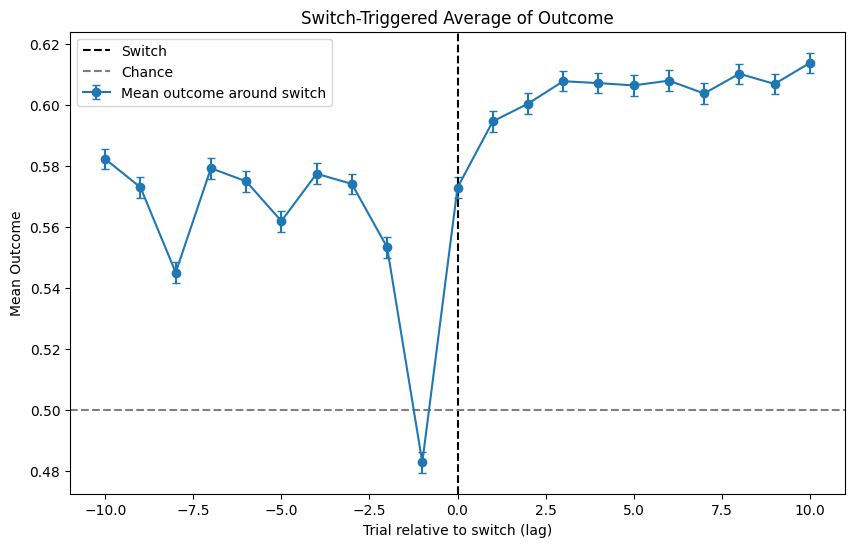

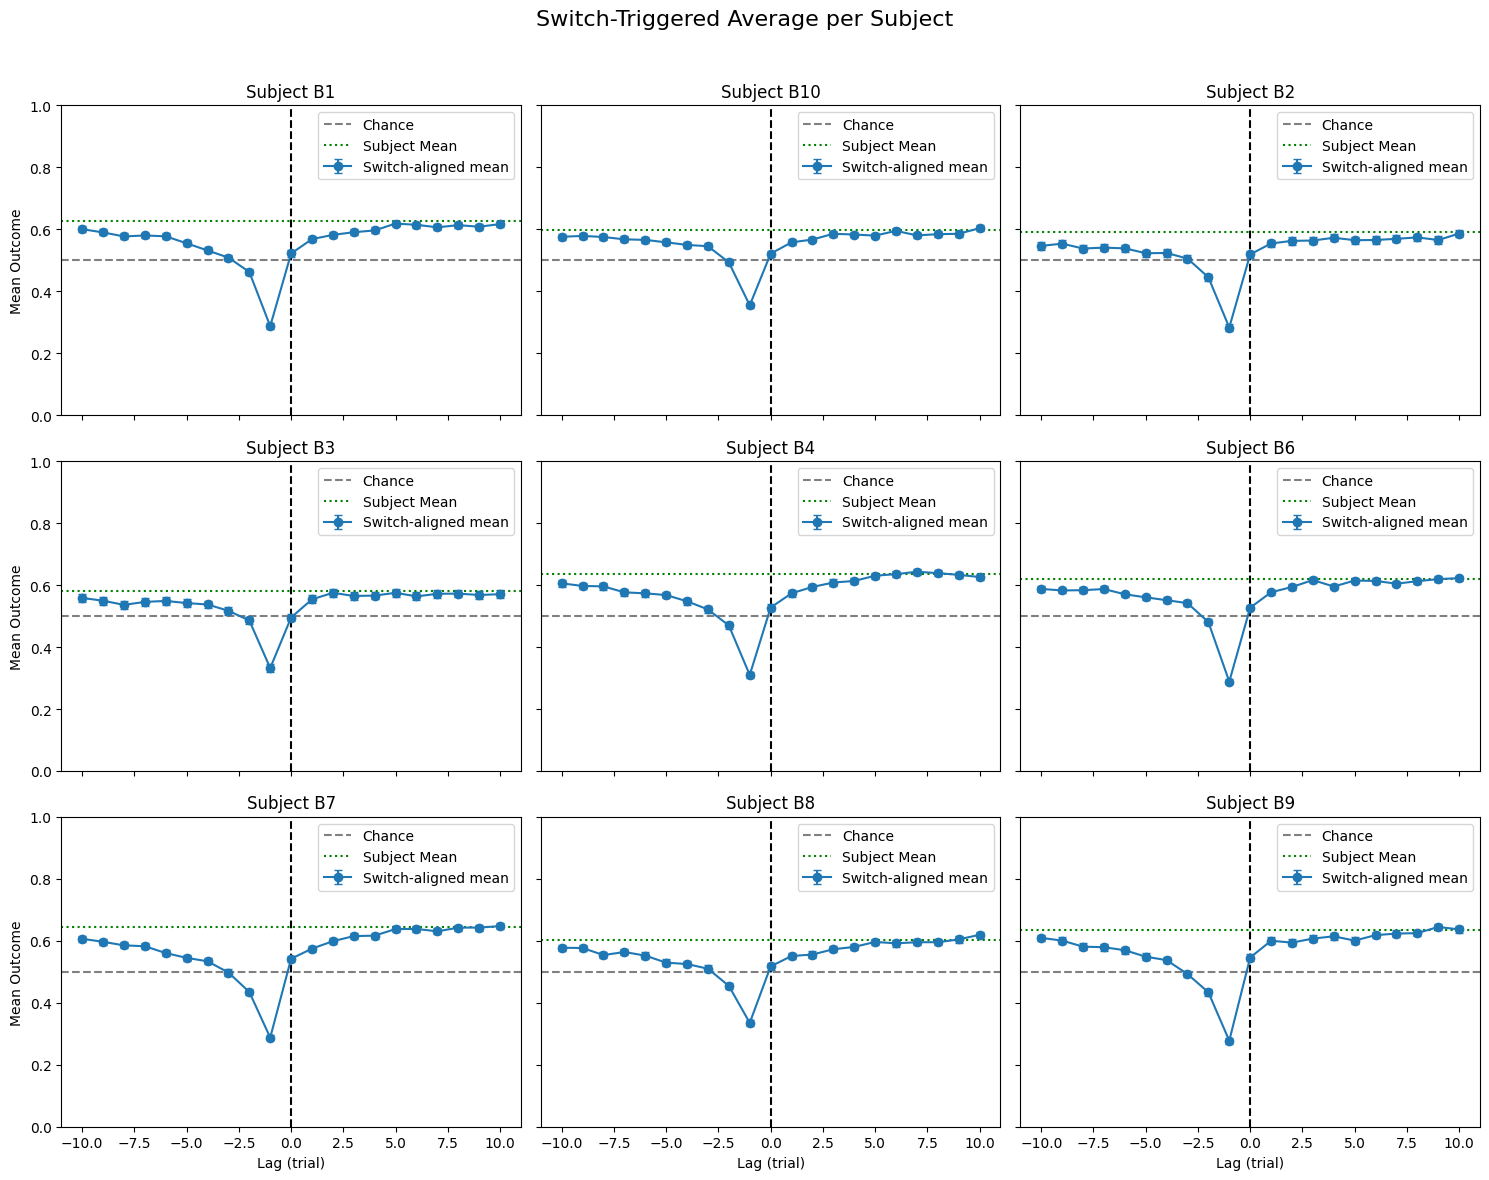

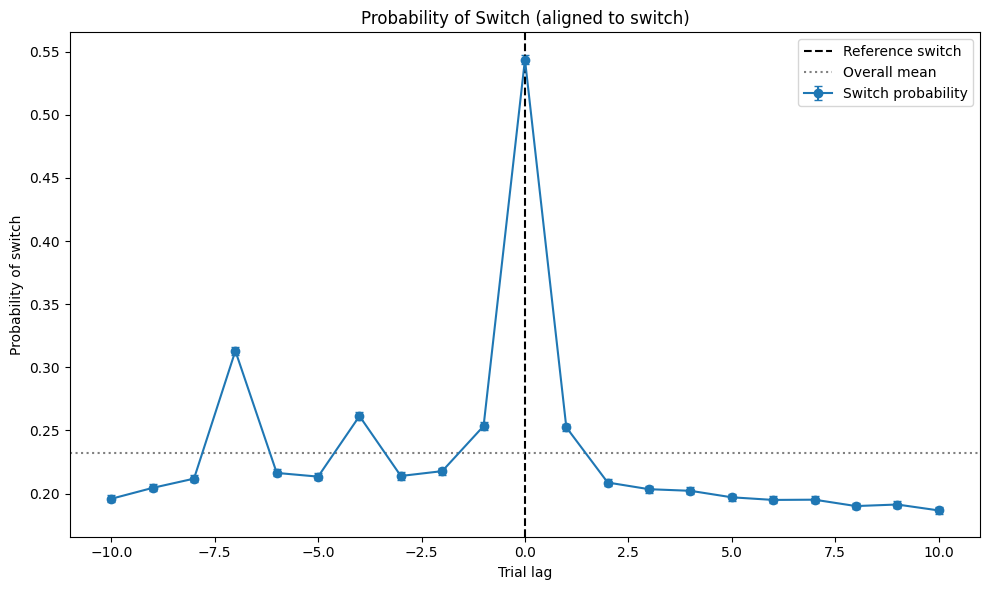

In [14]:
%matplotlib inline


def get_switch_indices(df1):
    # Trova gli switch come cambiamenti in switch_num
    return df1.index[df1['switch_num'] == 1]

def extract_outcome_windows(df1, window=5):
    """
    Estrae outcome nei trial attorno allo switch (da -window a +window)
    """
    switch_idx = get_switch_indices(df1)
    aligned_outcomes = []

    for idx in switch_idx:
        if idx - window < 0 or idx + window >= len(df1):
            continue  

        window_data = df1.iloc[idx - window : idx + window + 1].copy()
        lags = np.arange(-window, window + 1)
        outcomes = window_data['outcome_bool'].values

        for lag, outcome in zip(lags, outcomes):
            aligned_outcomes.append({
                'lag': lag,
                'outcome_bool': outcome
            })

    return pd.DataFrame(aligned_outcomes)

def plot_switch_triggered_average(aligned_df):
    mean_outcomes = aligned_df.groupby('lag')['outcome_bool'].mean()
    sem_outcomes = aligned_df.groupby('lag')['outcome_bool'].sem()

    plt.figure(figsize=(10, 6))
    plt.errorbar(mean_outcomes.index, mean_outcomes.values, yerr=sem_outcomes.values,
                 fmt='o-', capsize=3, label='Mean outcome around switch')

    plt.axvline(0, color='black', linestyle='--', label='Switch')
    plt.axhline(0.5, color='gray', linestyle='--', label='Chance')
    plt.title('Switch-Triggered Average of Outcome')
    plt.xlabel('Trial relative to switch (lag)')
    plt.ylabel('Mean Outcome')
    plt.legend()
    plt.show()

# --------- Usage ---------

aligned_df = extract_outcome_windows(new_df1, window=10)
plot_switch_triggered_average(aligned_df)

def extract_outcome_windows_per_subject(df1, window=5):
    """
    Estrae outcome attorno agli switch per ciascun soggetto
    """
    all_aligned = []

    for subj in df1['subject'].unique():
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        aligned = extract_outcome_windows(subj_df, window)
        aligned['subject'] = subj
        all_aligned.append(aligned)

    return pd.concat(all_aligned, ignore_index=True)

def extract_switch_prob_windows(df1, window=10):
    switch_idx = get_switch_indices(df1)
    aligned_switches = []

    for idx in switch_idx:
        if idx - window < 0 or idx + window >= len(df1):
            continue

        window_data = df1.iloc[idx - window:idx + window + 1].copy()
        lags = np.arange(-window, window + 1)
        switches = window_data['switch_num'].values  # 1 o 0

        for lag, switch in zip(lags, switches):
            aligned_switches.append({
                'lag': lag,
                'switch': switch
            })

    return pd.DataFrame(aligned_switches)

def plot_switch_probability(aligned_df):
    prob = aligned_df.groupby('lag')['switch'].mean()
    sem = aligned_df.groupby('lag')['switch'].sem()

    plt.figure(figsize=(10, 6))
    plt.errorbar(prob.index, prob.values, yerr=sem.values,
                 fmt='o-', capsize=3, label='Switch probability')

    plt.axvline(0, linestyle='--', color='black', label='Reference switch')
    plt.axhline(prob.mean(), linestyle=':', color='gray', label='Overall mean')
    plt.title('Probability of Switch (aligned to switch)')
    plt.xlabel('Trial lag')
    plt.ylabel('Probability of switch')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_switch_triggered_grid(aligned_df, full_df):
    subjects = sorted(aligned_df['subject'].unique())[:9]
    n_subjects = len(subjects)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        data = aligned_df[aligned_df['subject'] == subj]
        
        # ✅ Calcola media outcome su TUTTO il dataset per quel soggetto
        subject_mean = new_df1[new_df1['subject'] == subj]['outcome_bool'].mean()

        # Media e sem attorno allo switch
        mean_outcomes = data.groupby('lag')['outcome_bool'].mean()
        sem_outcomes = data.groupby('lag')['outcome_bool'].sem()

        ax.errorbar(mean_outcomes.index, mean_outcomes.values, yerr=sem_outcomes.values,
                    fmt='o-', capsize=3, label='Switch-aligned mean')

        # Linee di riferimento
        ax.axvline(0, color='black', linestyle='--')
        ax.axhline(0.5, color='gray', linestyle='--', label='Chance')
        ax.axhline(subject_mean, color='green', linestyle=':', label='Subject Mean')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        if i % 3 == 0:
            ax.set_ylabel('Mean Outcome')
        if i >= 6:
            ax.set_xlabel('Lag (trial)')

        ax.legend()

    for j in range(n_subjects, 9):
        fig.delaxes(axs[j])

    plt.suptitle('Switch-Triggered Average per Subject', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --------- Usage ---------
aligned_df_all = extract_outcome_windows_per_subject(new_df1, window=10)
plot_switch_triggered_grid(aligned_df_all, full_df=new_df1)
aligned_switch_df = extract_switch_prob_windows(new_df1, window=10)
plot_switch_probability(aligned_switch_df)


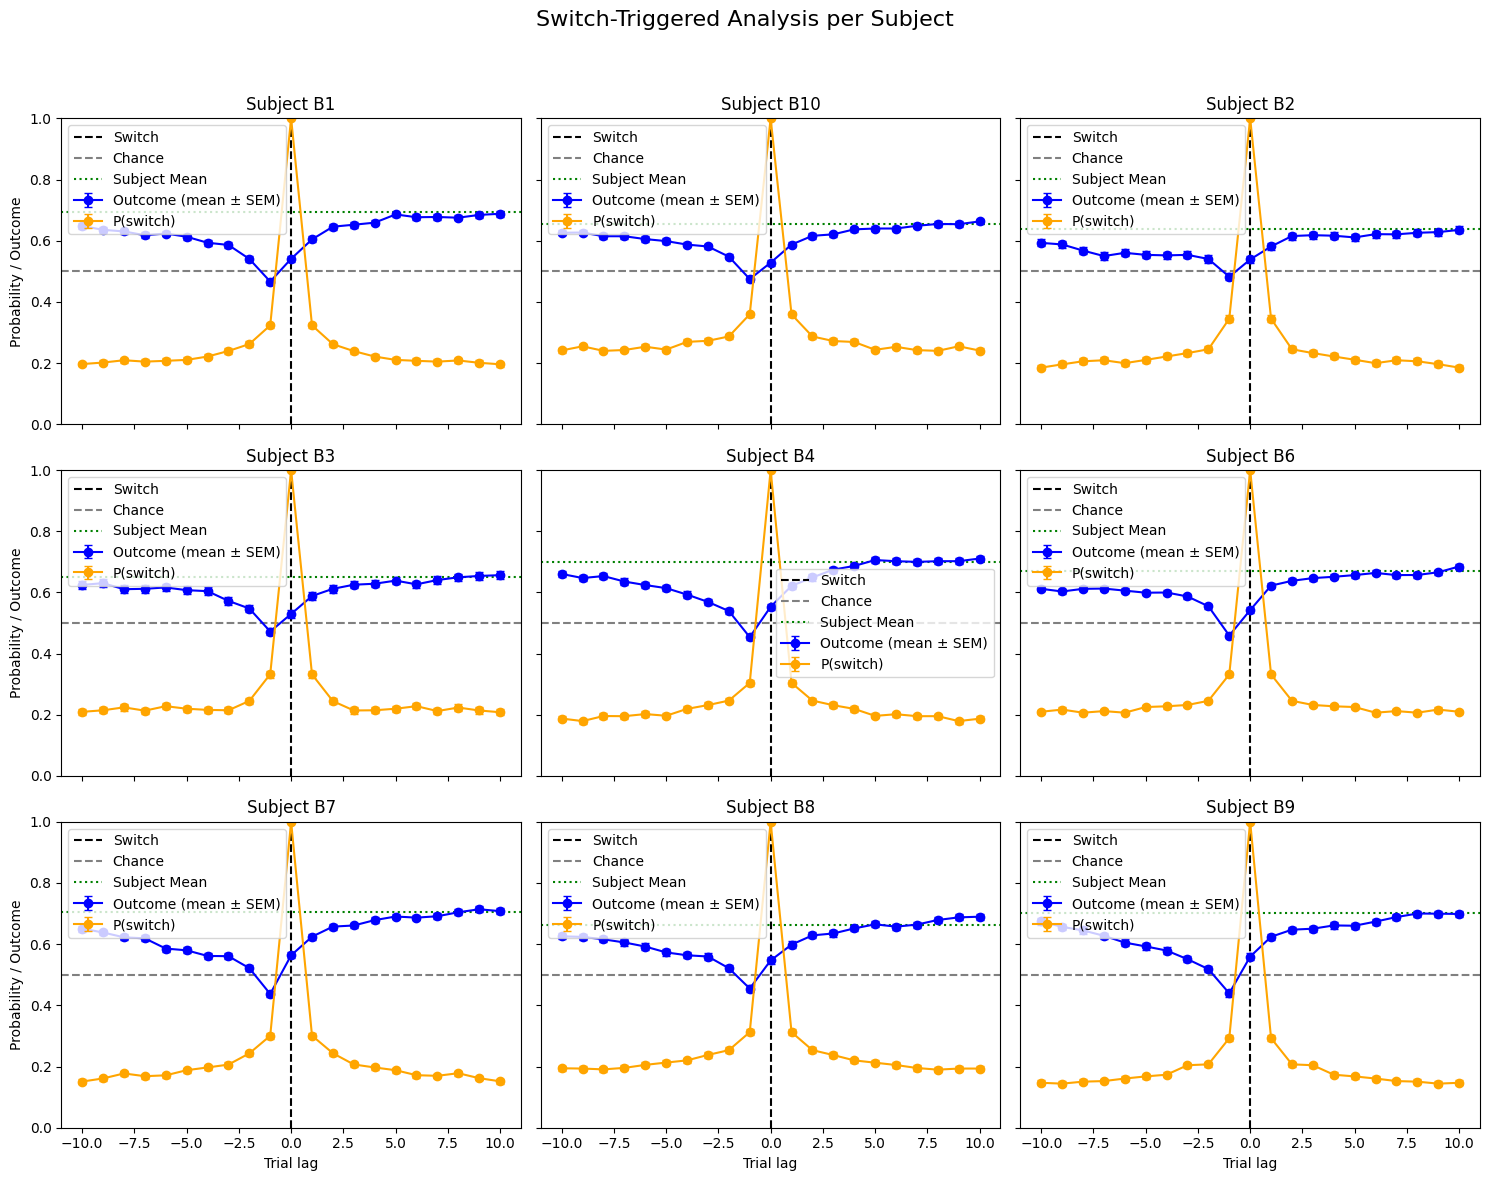

In [15]:

def plot_combined_switch_analysis(df1, window=10, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)

        # ----- Switch indices -----
        switch_idx = get_switch_indices(subj_df)

        # ----- Media outcome complessiva -----
        subject_mean = subj_df['fraction_of_correct_responses'].mean()


        # ----- Switch-triggered outcome -----
        aligned_outcome = []
        aligned_switches = []

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                aligned_outcome.append({'lag': lag, 'fraction_of_correct_responses': o})
                aligned_switches.append({'lag': lag, 'switch': s})

        # --- DF per outcome e switch ---
        outcome_df = pd.DataFrame(aligned_outcome)
        switch_df = pd.DataFrame(aligned_switches)

        # --- Plot outcome curve ---
        outcome_mean = outcome_df.groupby('lag')['fraction_of_correct_responses'].mean()
        outcome_sem = outcome_df.groupby('lag')['fraction_of_correct_responses'].sem()
        ax.errorbar(outcome_mean.index, outcome_mean.values, yerr=outcome_sem.values,
                    fmt='o-', capsize=3, label='Outcome (mean ± SEM)', color='blue')

        # --- Plot switch probability ---
        switch_prob = switch_df.groupby('lag')['switch'].mean()
        switch_sem = switch_df.groupby('lag')['switch'].sem()
        ax.errorbar(switch_prob.index, switch_prob.values, yerr=switch_sem.values,
                    fmt='o-', capsize=3, label='P(switch)', color='orange')

        # --- Linee di riferimento ---
        ax.axvline(0, linestyle='--', color='black', label='Switch')
        ax.axhline(0.5, linestyle='--', color='gray', label='Chance')
        ax.axhline(subject_mean, linestyle=':', color='green', label='Subject Mean')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        if i % ncols == 0:
            ax.set_ylabel('Probability / Outcome')
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel('Trial lag')
        ax.legend()

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])  # Rimuove subplot vuoti

    plt.suptitle('Switch-Triggered Analysis per Subject', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_combined_switch_analysis(new_df1, window=10)



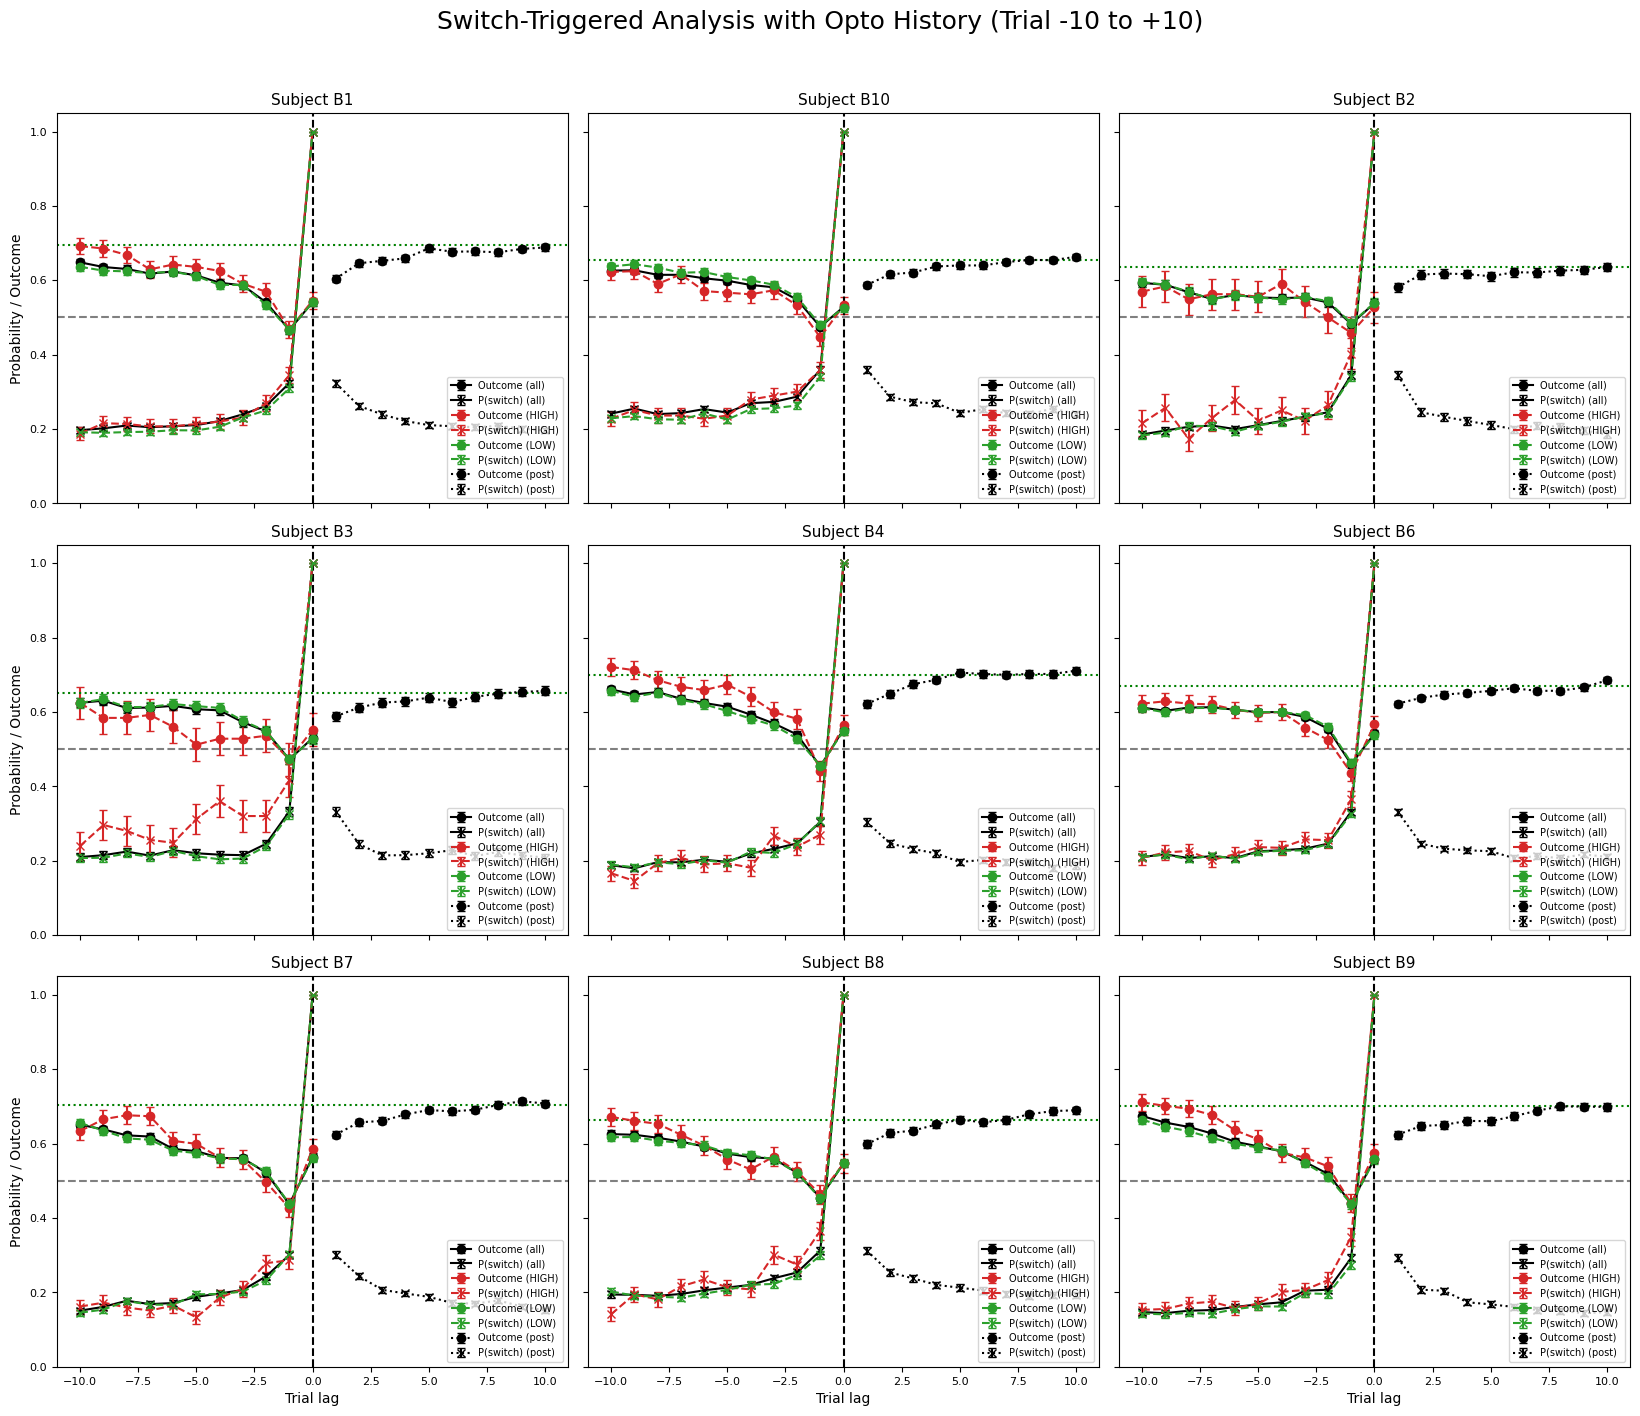

In [16]:
# Funzione migliorata per layout chiaro, pulito ed elegante

def plot_pre_switch_opto_grouped_v3(df1, window=10, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()

        aligned_outcome_general = []
        aligned_switches_general = []
        aligned_outcome_high = []
        aligned_outcome_low = []
        aligned_switches_high = []
        aligned_switches_low = []
        aligned_outcome_post = []
        aligned_switches_post = []

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            # Pre-switch (lag -window to 0)
            pre_lags = np.arange(-window, 1)
            outcome_vals = subj_df.iloc[idx - window:idx + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + 1]['switch_num'].values
            opto_vals = subj_df.iloc[idx - window:idx]['prev_opto_bool'].values

            for lag, o, s in zip(pre_lags, outcome_vals, switch_vals):
                aligned_outcome_general.append({'lag': lag, 'fraction_of_correct_responses': o})
                aligned_switches_general.append({'lag': lag, 'switch': s})

            opto_sum = np.sum(opto_vals)
            if opto_sum >= 4:
                for lag, o, s in zip(pre_lags, outcome_vals, switch_vals):
                    aligned_outcome_high.append({'lag': lag, 'fraction_of_correct_responses': o})
                    aligned_switches_high.append({'lag': lag, 'switch': s})
            elif opto_sum <= 3:
                for lag, o, s in zip(pre_lags, outcome_vals, switch_vals):
                    aligned_outcome_low.append({'lag': lag, 'fraction_of_correct_responses': o})
                    aligned_switches_low.append({'lag': lag, 'switch': s})

            # Post-switch (lag 1 to +window)
            post_lags = np.arange(1, window + 1)
            outcome_post = subj_df.iloc[idx + 1:idx + window + 1]['fraction_of_correct_responses'].values
            switch_post = subj_df.iloc[idx + 1:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(post_lags, outcome_post, switch_post):
                aligned_outcome_post.append({'lag': lag, 'fraction_of_correct_responses': o})
                aligned_switches_post.append({'lag': lag, 'switch': s})

        # Convert to DataFrames
        def mean_sem(df, value_col='fraction_of_correct_responses'):
            return df.groupby('lag')[value_col].mean(), df.groupby('lag')[value_col].sem()

        outcome_df = pd.DataFrame(aligned_outcome_general)
        switch_df = pd.DataFrame(aligned_switches_general)
        high_outcome_df = pd.DataFrame(aligned_outcome_high)
        high_switch_df = pd.DataFrame(aligned_switches_high)
        low_outcome_df = pd.DataFrame(aligned_outcome_low)
        low_switch_df = pd.DataFrame(aligned_switches_low)
        post_outcome_df = pd.DataFrame(aligned_outcome_post)
        post_switch_df = pd.DataFrame(aligned_switches_post)

        # Plotting
        def plot_curve(ax, df, label, color, marker, linestyle, value_col):
            if not df.empty:
                mean, sem = mean_sem(df, value_col)
                ax.errorbar(mean.index, mean.values, yerr=sem.values,
                            fmt=marker, linestyle=linestyle, capsize=3,
                            label=label, color=color)

        # Plot curves
        plot_curve(ax, outcome_df, 'Outcome (all)', 'black', 'o', '-', 'fraction_of_correct_responses')
        plot_curve(ax, switch_df, 'P(switch) (all)', 'black', 'x', '-', 'switch')
        plot_curve(ax, high_outcome_df, 'Outcome (HIGH)', '#d62728', 'o', '--', 'fraction_of_correct_responses')
        plot_curve(ax, high_switch_df, 'P(switch) (HIGH)', '#d62728', 'x', '--', 'switch')
        plot_curve(ax, low_outcome_df, 'Outcome (LOW)', '#2ca02c', 'o', '--', 'fraction_of_correct_responses')
        plot_curve(ax, low_switch_df, 'P(switch) (LOW)', '#2ca02c', 'x', '--', 'switch')
        plot_curve(ax, post_outcome_df, 'Outcome (post)', 'black', 'o', ':', 'fraction_of_correct_responses')
        plot_curve(ax, post_switch_df, 'P(switch) (post)', 'black', 'x', ':', 'switch')

        # Reference lines
        ax.axvline(0, linestyle='--', color='black')
        ax.axhline(0.5, linestyle='--', color='gray')
        ax.axhline(subject_mean, linestyle=':', color='green')

        # Formatting
        ax.set_title(f'Subject {subj}', fontsize=11)
        ax.set_ylim(0, 1.05)
        if i % ncols == 0:
            ax.set_ylabel('Probability / Outcome')
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel('Trial lag')
        ax.tick_params(axis='both', labelsize=8)
        ax.legend(fontsize=7, loc='lower right')

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle('Switch-Triggered Analysis with Opto History (Trial -10 to +10)', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_pre_switch_opto_grouped_v3(new_df1, window=10)

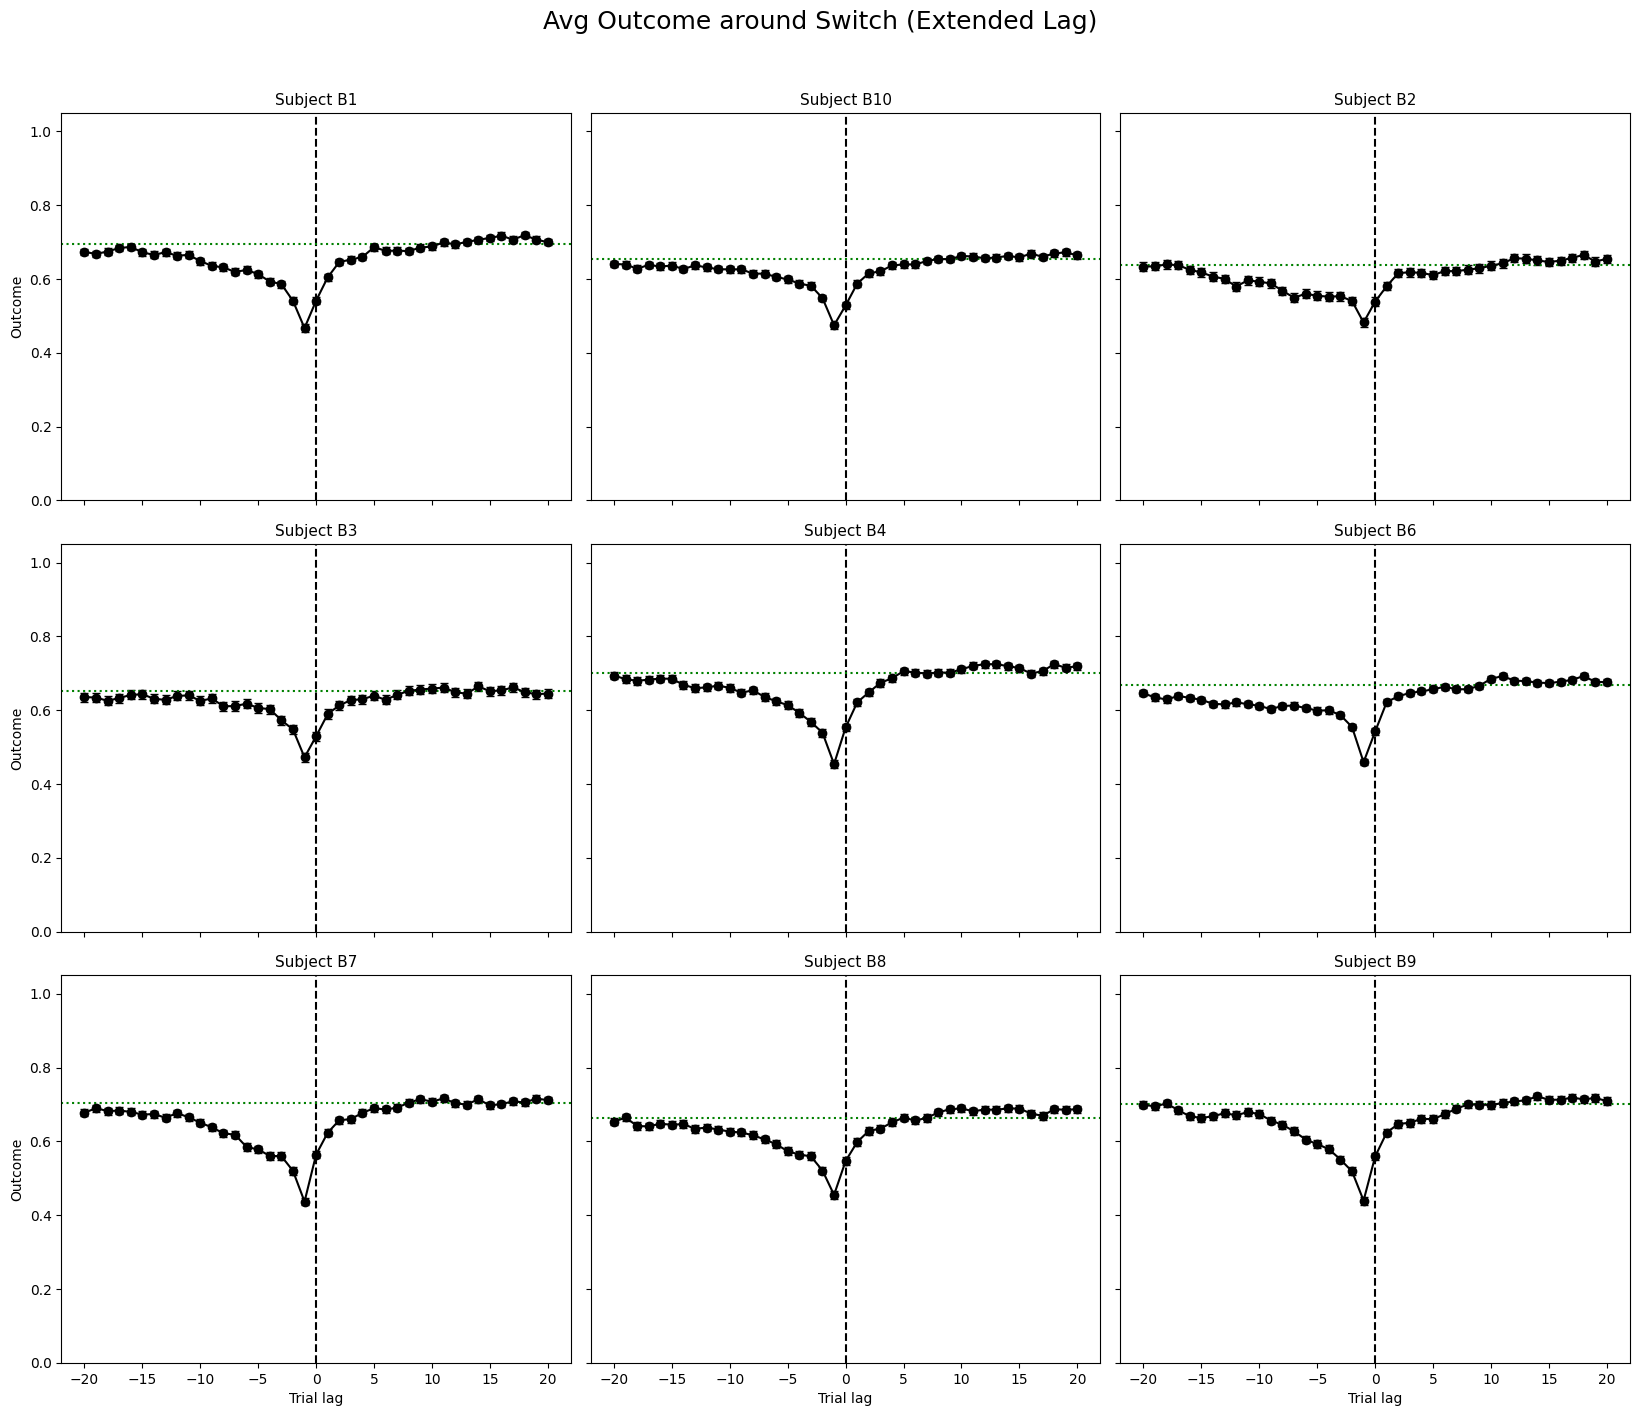

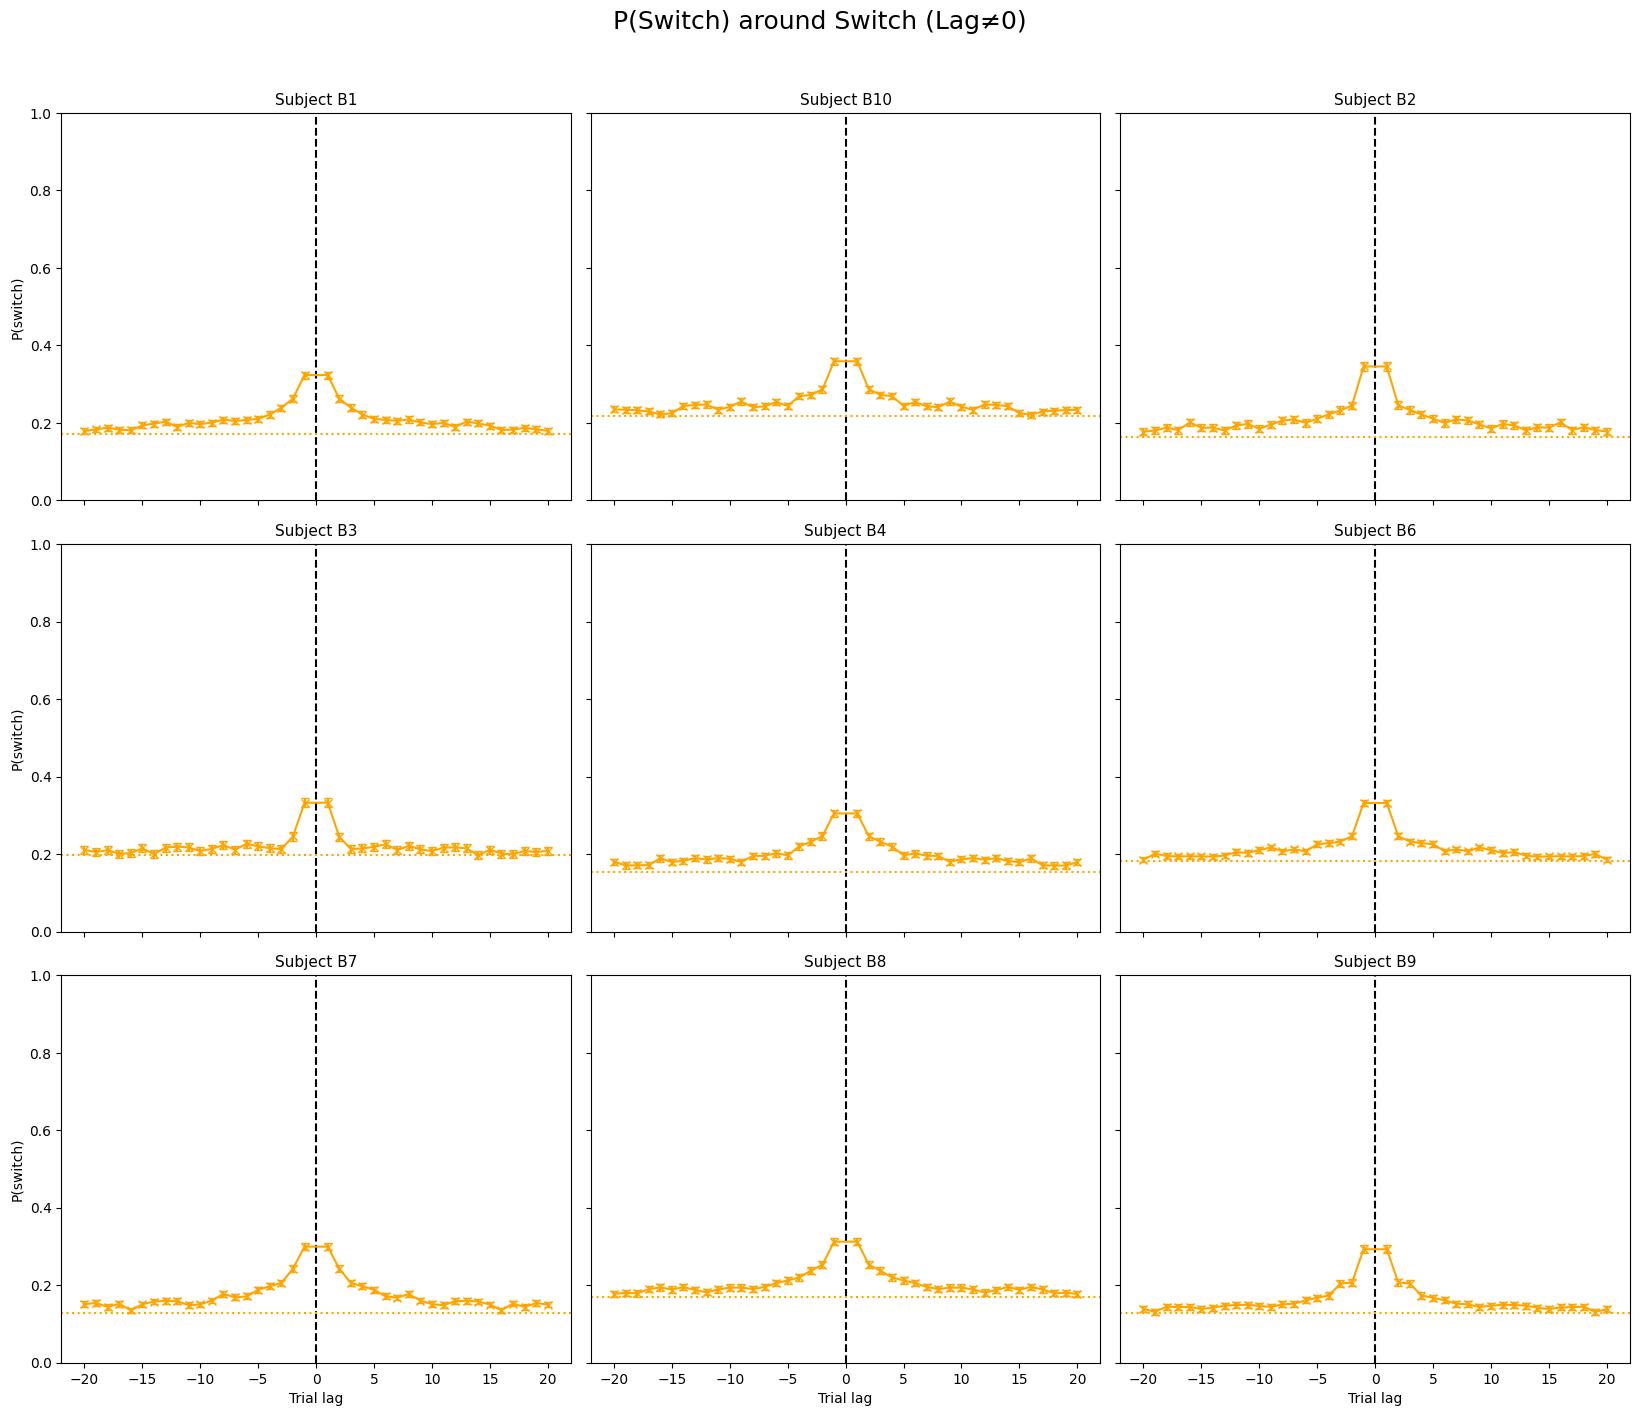

In [17]:
# Codice che crea TUTTI i plot richiesti:
# 1. Outcome vs trial lag (esteso)
# 2. Switch vs trial lag (esteso, senza lag=0)
# 3. Session-wise trend: avg outcome and switch over time (binning)

def plot_outcome_and_switch_lag_analysis(df1, window=20, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    # Prepara le figure SEPARATE
    fig_outcome, axs_outcome = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    fig_switch, axs_switch = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs_outcome = axs_outcome.flatten()
    axs_switch = axs_switch.flatten()

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        global_switch_mean = subj_df['switch_num'].mean()

        aligned_outcome = []
        aligned_switch = []

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                aligned_outcome.append({'lag': lag, 'value': o})
                aligned_switch.append({'lag': lag, 'value': s})

        outcome_df = pd.DataFrame(aligned_outcome)
        switch_df = pd.DataFrame(aligned_switch)
        switch_df = switch_df[switch_df['lag'] != 0]  # rimuovi lag = 0 per switch

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        # OUTCOME plot
        ax_out = axs_outcome[i]
        if not outcome_df.empty:
            mean, sem = mean_sem(outcome_df)
            ax_out.errorbar(mean.index, mean.values, yerr=sem.values, fmt='o-', capsize=3, color='black')
        ax_out.axvline(0, linestyle='--', color='black')
        ax_out.axhline(subject_mean, linestyle=':', color='green')
        ax_out.set_title(f'Subject {subj}', fontsize=11)
        ax_out.set_ylim(0, 1.05)
        if i % ncols == 0:
            ax_out.set_ylabel('Outcome')
        if i >= (nrows - 1) * ncols:
            ax_out.set_xlabel('Trial lag')

        # SWITCH plot
        ax_sw = axs_switch[i]
        if not switch_df.empty:
            mean_s, sem_s = mean_sem(switch_df)
            ax_sw.errorbar(mean_s.index, mean_s.values, yerr=sem_s.values, fmt='x-', capsize=3, color='orange')
        ax_sw.axvline(0, linestyle='--', color='black')
        ax_sw.axhline(global_switch_mean, linestyle=':', color='orange')
        ax_sw.set_title(f'Subject {subj}', fontsize=11)
        ax_sw.set_ylim(0, 1)
        if i % ncols == 0:
            ax_sw.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax_sw.set_xlabel('Trial lag')

    # Rimuove subplot vuoti
    for j in range(n, len(axs_outcome)):
        fig_outcome.delaxes(axs_outcome[j])
        fig_switch.delaxes(axs_switch[j])

    fig_outcome.suptitle('Avg Outcome around Switch (Extended Lag)', fontsize=18)
    fig_switch.suptitle('P(Switch) around Switch (Lag≠0)', fontsize=18)
    fig_outcome.tight_layout(rect=[0, 0, 1, 0.96])
    fig_switch.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_sessionwise_binned_outcome_and_switch(df1, bin_size=10):
    df1 = df1.copy()
    df1['trial_bin'] = (df1['trial_index'] // bin_size) * bin_size

    grouped = df1.groupby(['subject', 'trial_bin'])
    outcome_mean = grouped['fraction_of_correct_responses'].mean().reset_index()
    switch_mean = grouped['switch_num'].mean().reset_index()

    subjects = sorted(df1['subject'].unique())
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.5 * nrows), sharex=False)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_out = outcome_mean[outcome_mean['subject'] == subj]
        subj_sw = switch_mean[switch_mean['subject'] == subj]

        ax.plot(subj_out['trial_bin'], subj_out['fraction_of_correct_responses'], label='Avg Outcome', color='black', marker='o')
        ax.plot(subj_sw['trial_bin'], subj_sw['switch_num'], label='P(Switch)', color='orange', marker='x')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        ax.set_xlabel('Trial in session')
        ax.set_ylabel('Value')
        ax.legend(fontsize=8)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle('Session-wise Avg Outcome and P(Switch) (10-trial bins)', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_outcome_and_switch_lag_analysis(new_df1, window=20)

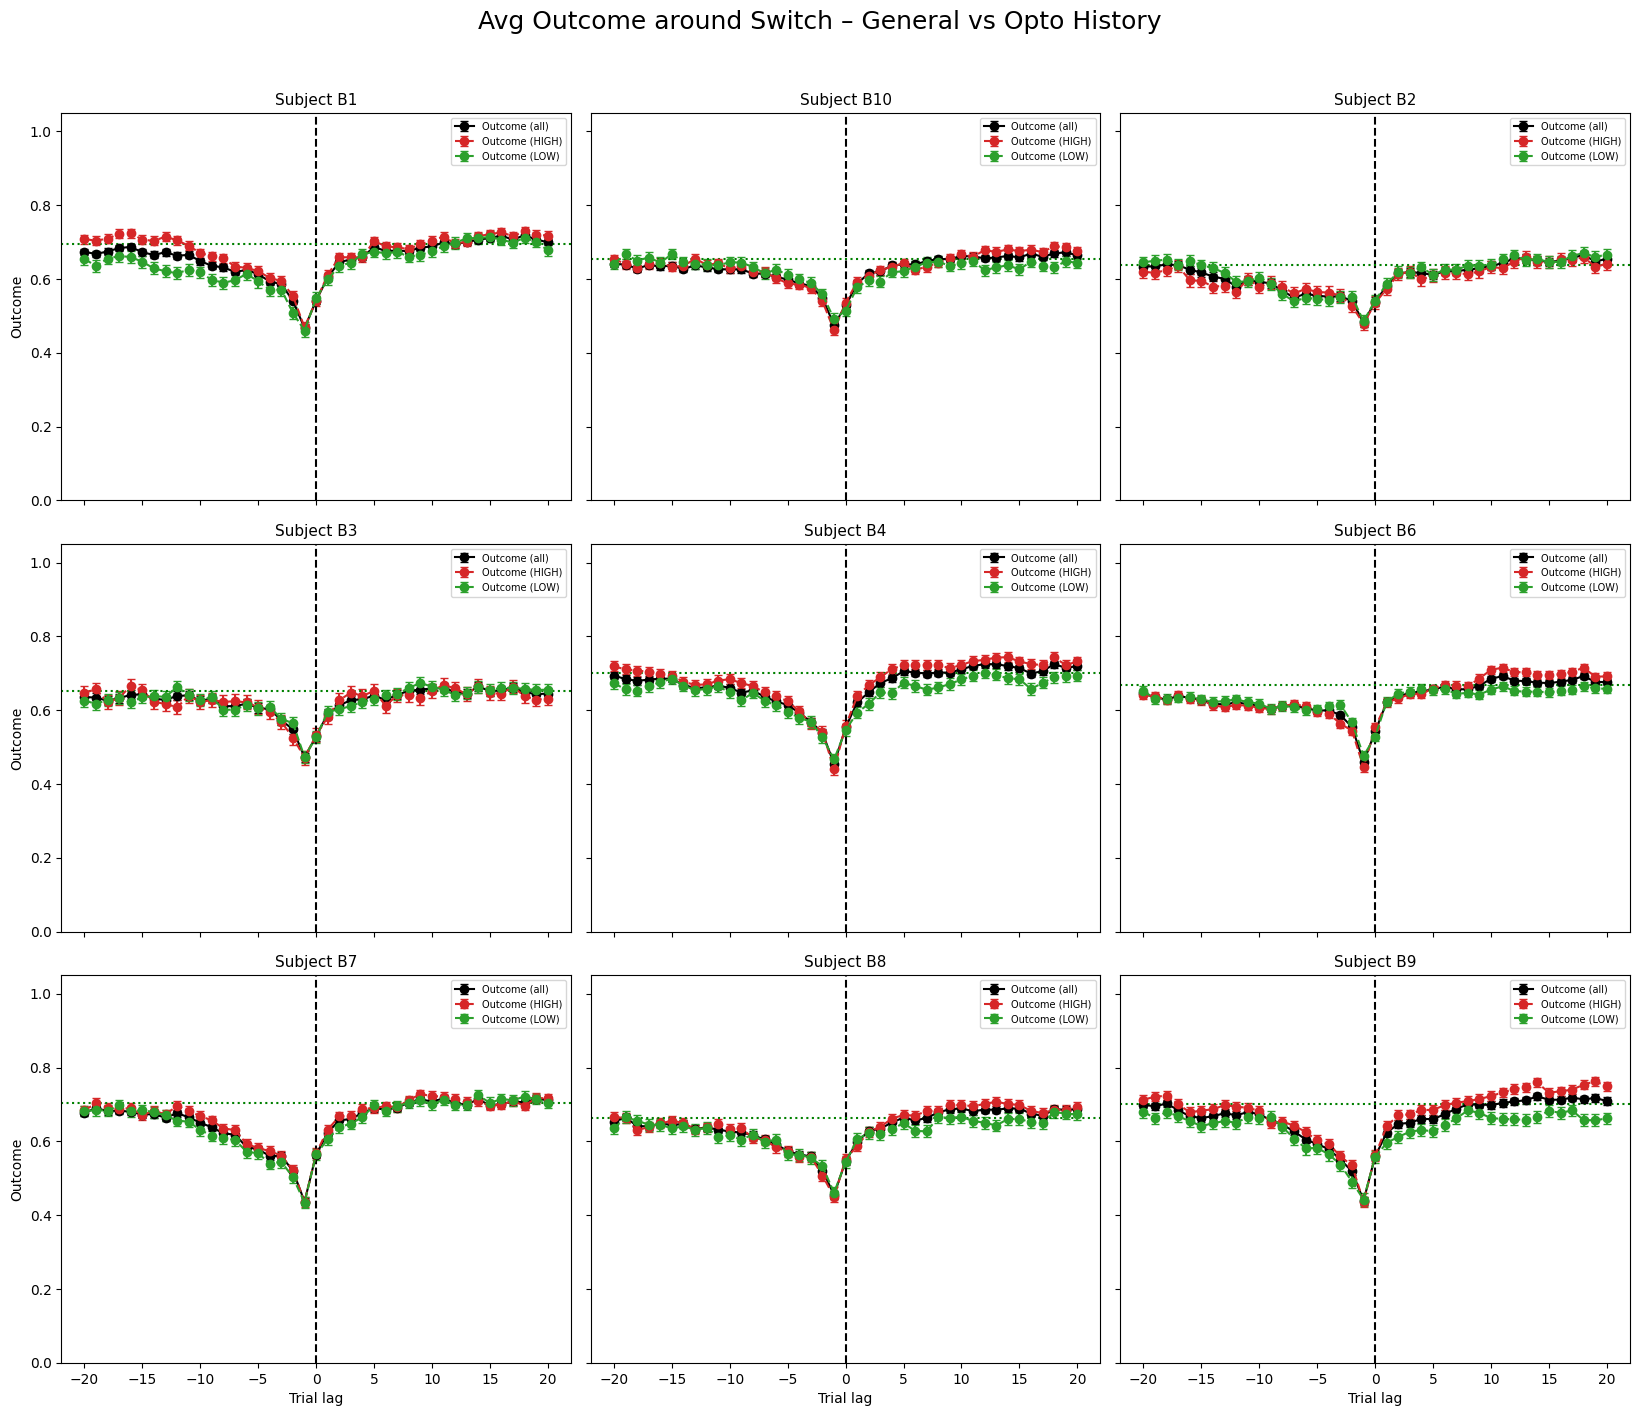

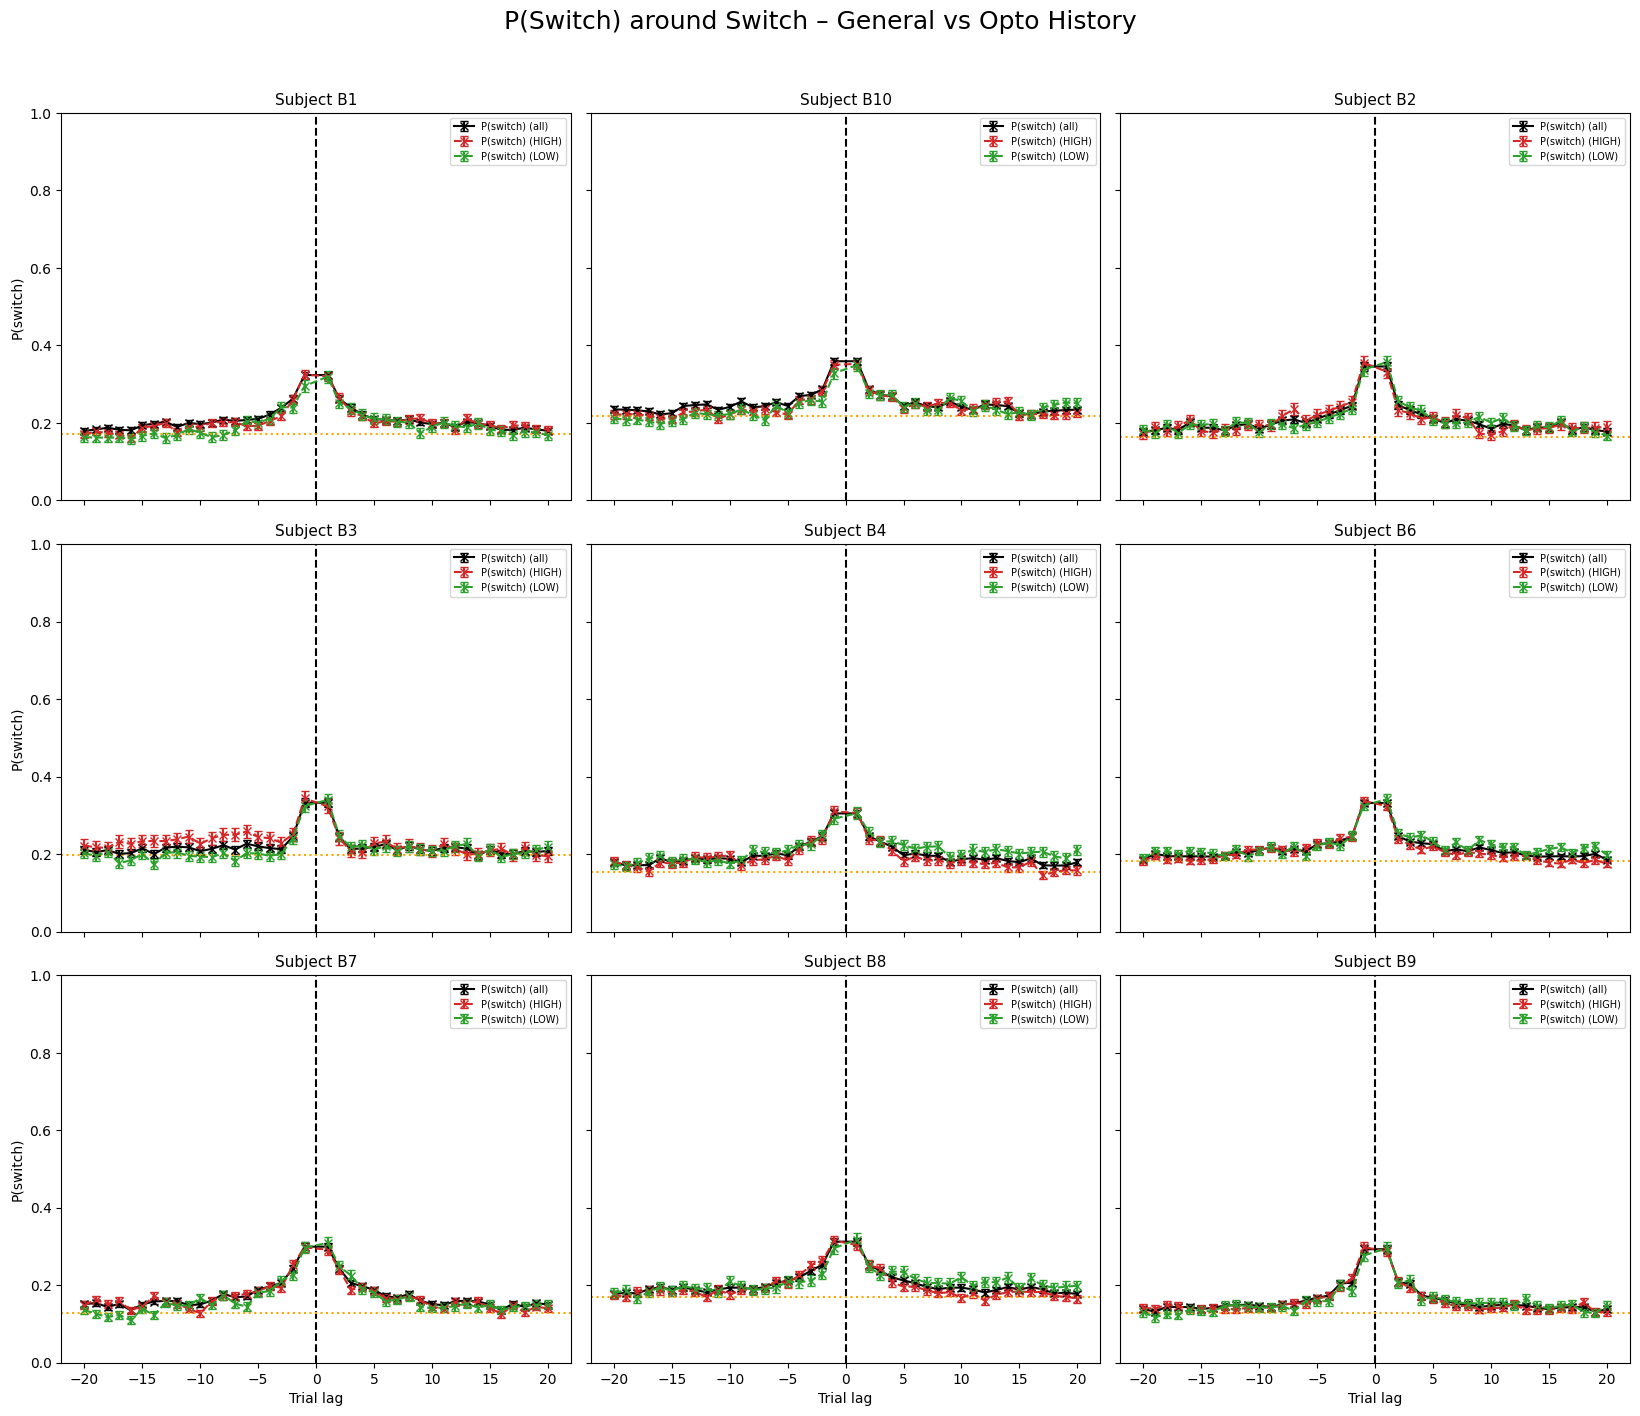

In [18]:
# Funzione aggiornata per includere curve LOW e HIGH optogenetiche nei due plot separati

def plot_outcome_and_switch_lag_analysis_with_opto(df1, window=20, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig_outcome, axs_outcome = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    fig_switch, axs_switch = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs_outcome = axs_outcome.flatten()
    axs_switch = axs_switch.flatten()

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        global_switch_mean = subj_df['switch_num'].mean()

        data = {
            'general_outcome': [],
            'general_switch': [],
            'high_outcome': [],
            'high_switch': [],
            'low_outcome': [],
            'low_switch': []
        }

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values
            opto_vals = subj_df.iloc[idx - window:idx]['prev_opto_bool'].values  # prev opto only before switch

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                data['general_outcome'].append({'lag': lag, 'value': o})
                data['general_switch'].append({'lag': lag, 'value': s})

            opto_sum = np.sum(opto_vals)
            if opto_sum >= 4:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['high_outcome'].append({'lag': lag, 'value': o})
                    data['high_switch'].append({'lag': lag, 'value': s})
            elif opto_sum <= 3:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['low_outcome'].append({'lag': lag, 'value': o})
                    data['low_switch'].append({'lag': lag, 'value': s})

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        def plot_errorbar(ax, df, label, color, marker, linestyle):
            if not df.empty:
                mean, sem = mean_sem(df)
                ax.errorbar(mean.index, mean.values, yerr=sem.values, fmt=marker, linestyle=linestyle,
                            capsize=3, label=label, color=color)

        # OUTCOME PLOT
        ax_out = axs_outcome[i]
        plot_errorbar(ax_out, pd.DataFrame(data['general_outcome']), 'Outcome (all)', 'black', 'o', '-')
        plot_errorbar(ax_out, pd.DataFrame(data['high_outcome']), 'Outcome (HIGH)', '#d62728', 'o', '--')
        plot_errorbar(ax_out, pd.DataFrame(data['low_outcome']), 'Outcome (LOW)', '#2ca02c', 'o', '--')
        ax_out.axvline(0, linestyle='--', color='black')
        ax_out.axhline(subject_mean, linestyle=':', color='green')
        ax_out.set_title(f'Subject {subj}', fontsize=11)
        ax_out.set_ylim(0, 1.05)
        if i % ncols == 0:
            ax_out.set_ylabel('Outcome')
        if i >= (nrows - 1) * ncols:
            ax_out.set_xlabel('Trial lag')
        ax_out.legend(fontsize=7)

        # SWITCH PLOT
        ax_sw = axs_switch[i]
        plot_errorbar(ax_sw, pd.DataFrame(data['general_switch']).query('lag != 0'), 'P(switch) (all)', 'black', 'x', '-')
        plot_errorbar(ax_sw, pd.DataFrame(data['high_switch']).query('lag != 0'), 'P(switch) (HIGH)', '#d62728', 'x', '--')
        plot_errorbar(ax_sw, pd.DataFrame(data['low_switch']).query('lag != 0'), 'P(switch) (LOW)', '#2ca02c', 'x', '--')
        ax_sw.axvline(0, linestyle='--', color='black')
        ax_sw.axhline(global_switch_mean, linestyle=':', color='orange')
        ax_sw.set_title(f'Subject {subj}', fontsize=11)
        ax_sw.set_ylim(0, 1)
        if i % ncols == 0:
            ax_sw.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax_sw.set_xlabel('Trial lag')
        ax_sw.legend(fontsize=7)

    for j in range(n, len(axs_outcome)):
        fig_outcome.delaxes(axs_outcome[j])
        fig_switch.delaxes(axs_switch[j])

    fig_outcome.suptitle('Avg Outcome around Switch – General vs Opto History', fontsize=18)
    fig_switch.suptitle('P(Switch) around Switch – General vs Opto History', fontsize=18)
    fig_outcome.tight_layout(rect=[0, 0, 1, 0.96])
    fig_switch.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_outcome_and_switch_lag_analysis_with_opto(new_df1, window=20)

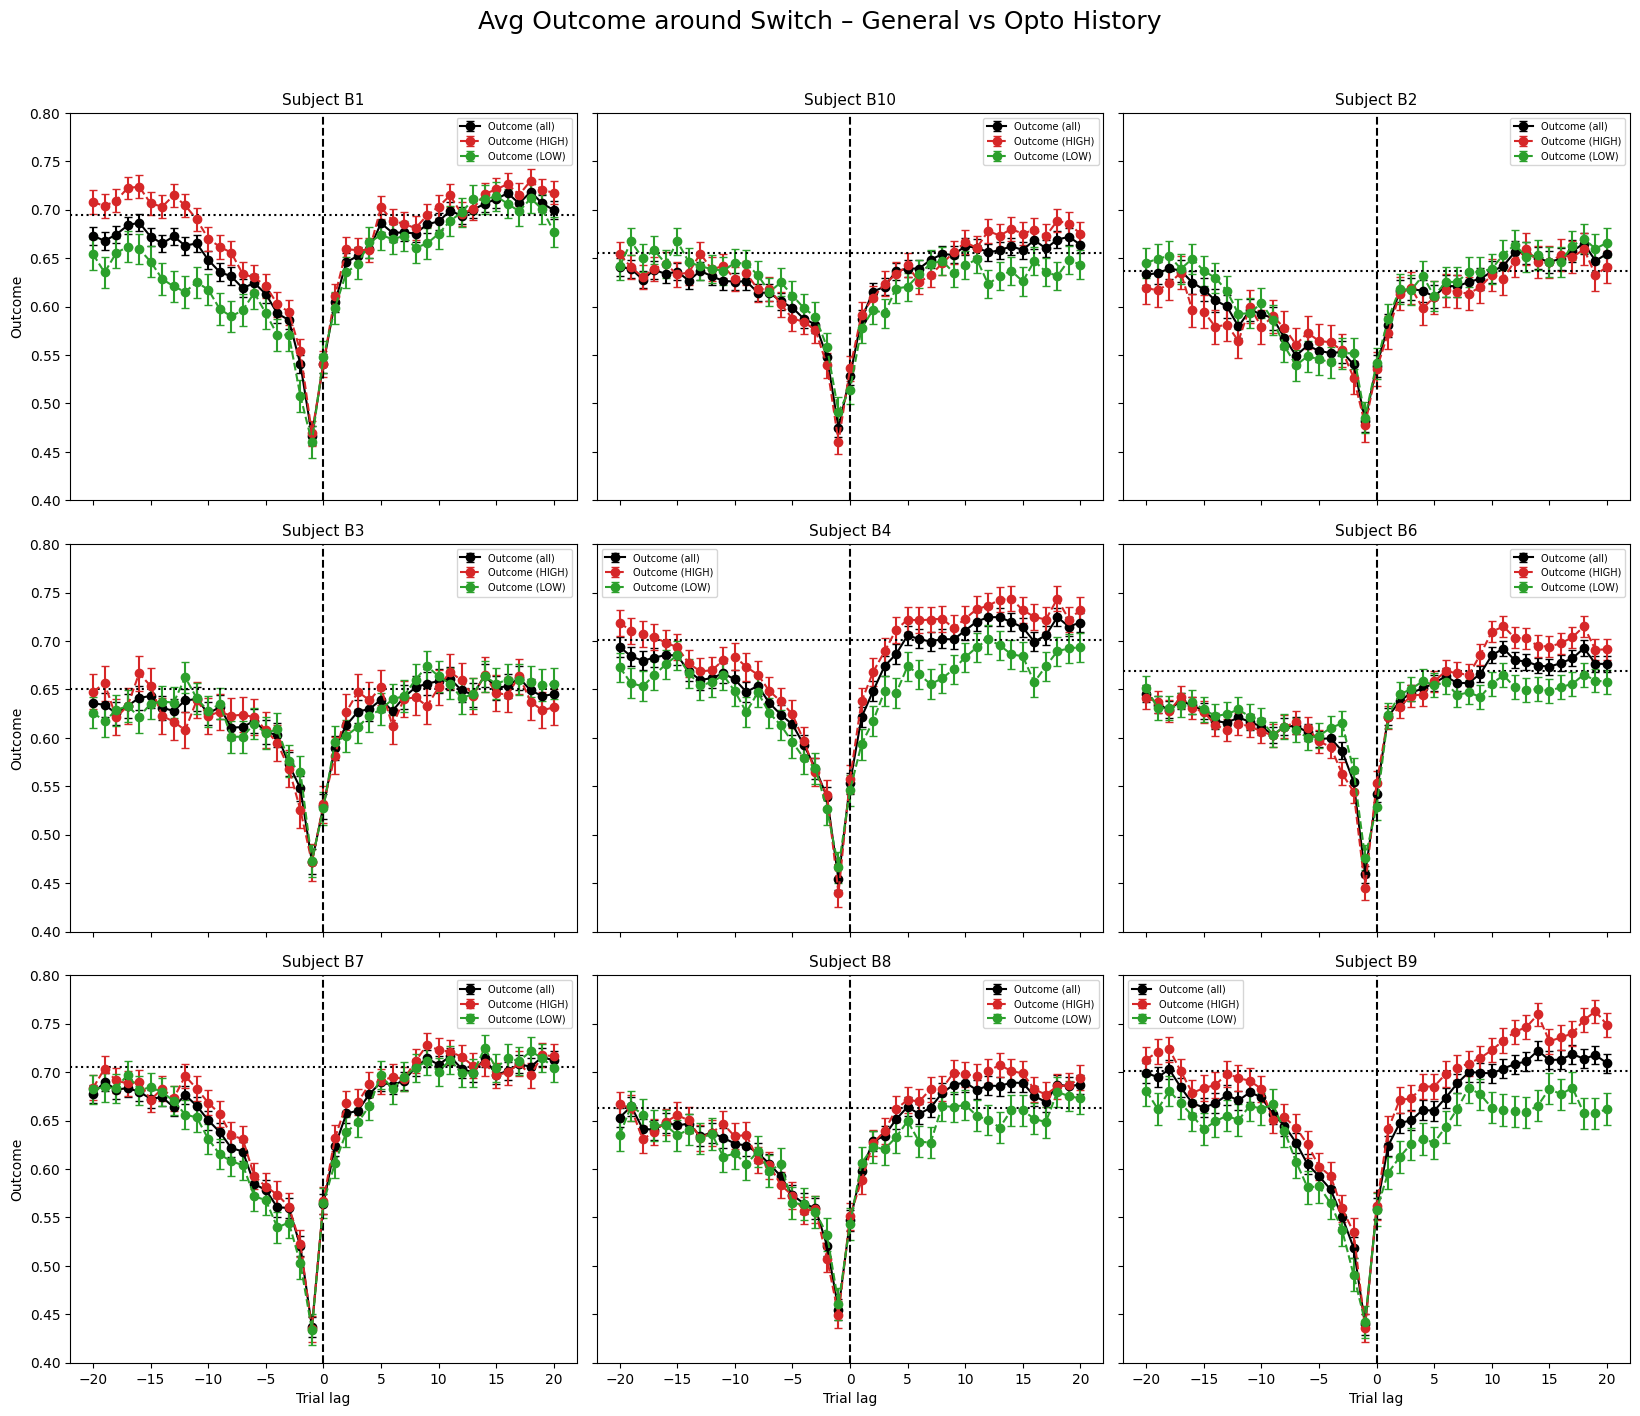

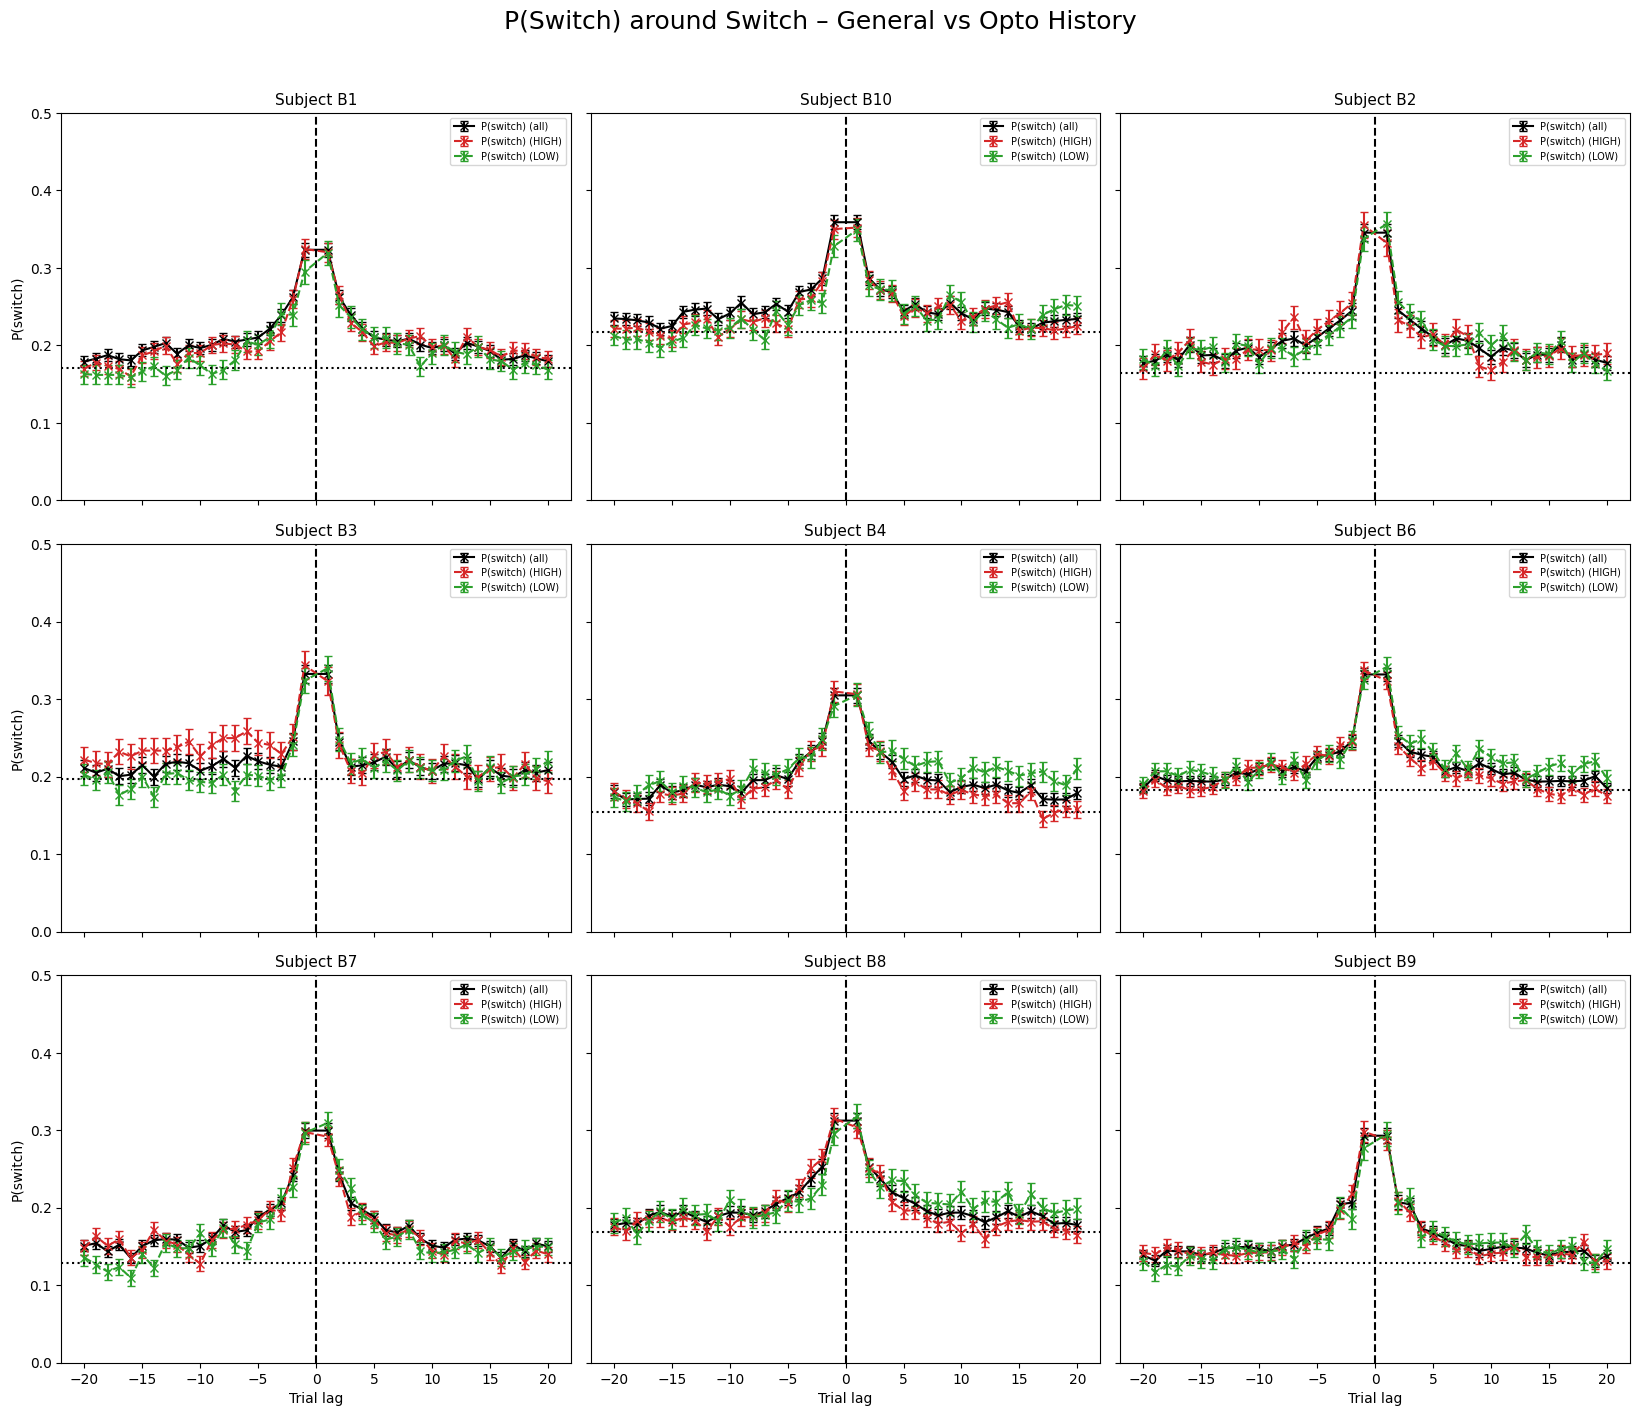

In [19]:
def plot_outcome_and_switch_lag_analysis_with_opto_v2(df1, window=20, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig_outcome, axs_outcome = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    fig_switch, axs_switch = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs_outcome = axs_outcome.flatten()
    axs_switch = axs_switch.flatten()

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        global_switch_mean = subj_df['switch_num'].mean()

        data = {
            'general_outcome': [],
            'general_switch': [],
            'high_outcome': [],
            'high_switch': [],
            'low_outcome': [],
            'low_switch': []
        }

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values
            opto_vals = subj_df.iloc[idx - window:idx]['prev_opto_bool'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                data['general_outcome'].append({'lag': lag, 'value': o})
                data['general_switch'].append({'lag': lag, 'value': s})

            opto_sum = np.sum(opto_vals)
            if opto_sum >= 4:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['high_outcome'].append({'lag': lag, 'value': o})
                    data['high_switch'].append({'lag': lag, 'value': s})
            elif opto_sum <= 3:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['low_outcome'].append({'lag': lag, 'value': o})
                    data['low_switch'].append({'lag': lag, 'value': s})

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        def plot_errorbar(ax, df, label, color, marker, linestyle):
            if not df.empty:
                mean, sem = mean_sem(df)
                ax.errorbar(mean.index, mean.values, yerr=sem.values, fmt=marker, linestyle=linestyle,
                            capsize=3, label=label, color=color)

        # OUTCOME PLOT
        ax_out = axs_outcome[i]
        plot_errorbar(ax_out, pd.DataFrame(data['general_outcome']), 'Outcome (all)', 'black', 'o', '-')
        plot_errorbar(ax_out, pd.DataFrame(data['high_outcome']), 'Outcome (HIGH)', '#d62728', 'o', '--')
        plot_errorbar(ax_out, pd.DataFrame(data['low_outcome']), 'Outcome (LOW)', '#2ca02c', 'o', '--')
        ax_out.axvline(0, linestyle='--', color='black')
        ax_out.axhline(subject_mean, linestyle=':', color='black')
        ax_out.set_title(f'Subject {subj}', fontsize=11)
        ax_out.set_ylim(0.4, 0.8)
        if i % ncols == 0:
            ax_out.set_ylabel('Outcome')
        if i >= (nrows - 1) * ncols:
            ax_out.set_xlabel('Trial lag')
        ax_out.legend(fontsize=7)

        # SWITCH PLOT
        ax_sw = axs_switch[i]
        plot_errorbar(ax_sw, pd.DataFrame(data['general_switch']).query('lag != 0'), 'P(switch) (all)', 'black', 'x', '-')
        plot_errorbar(ax_sw, pd.DataFrame(data['high_switch']).query('lag != 0'), 'P(switch) (HIGH)', '#d62728', 'x', '--')
        plot_errorbar(ax_sw, pd.DataFrame(data['low_switch']).query('lag != 0'), 'P(switch) (LOW)', '#2ca02c', 'x', '--')
        ax_sw.axvline(0, linestyle='--', color='black')
        ax_sw.axhline(global_switch_mean, linestyle=':', color='black')
        ax_sw.set_title(f'Subject {subj}', fontsize=11)
        ax_sw.set_ylim(0, 0.5)
        if i % ncols == 0:
            ax_sw.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax_sw.set_xlabel('Trial lag')
        ax_sw.legend(fontsize=7)

    for j in range(n, len(axs_outcome)):
        fig_outcome.delaxes(axs_outcome[j])
        fig_switch.delaxes(axs_switch[j])

    fig_outcome.suptitle('Avg Outcome around Switch – General vs Opto History', fontsize=18)
    fig_switch.suptitle('P(Switch) around Switch – General vs Opto History', fontsize=18)
    fig_outcome.tight_layout(rect=[0, 0, 1, 0.96])
    fig_switch.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_outcome_and_switch_lag_analysis_with_opto_v2(new_df1, window=20)


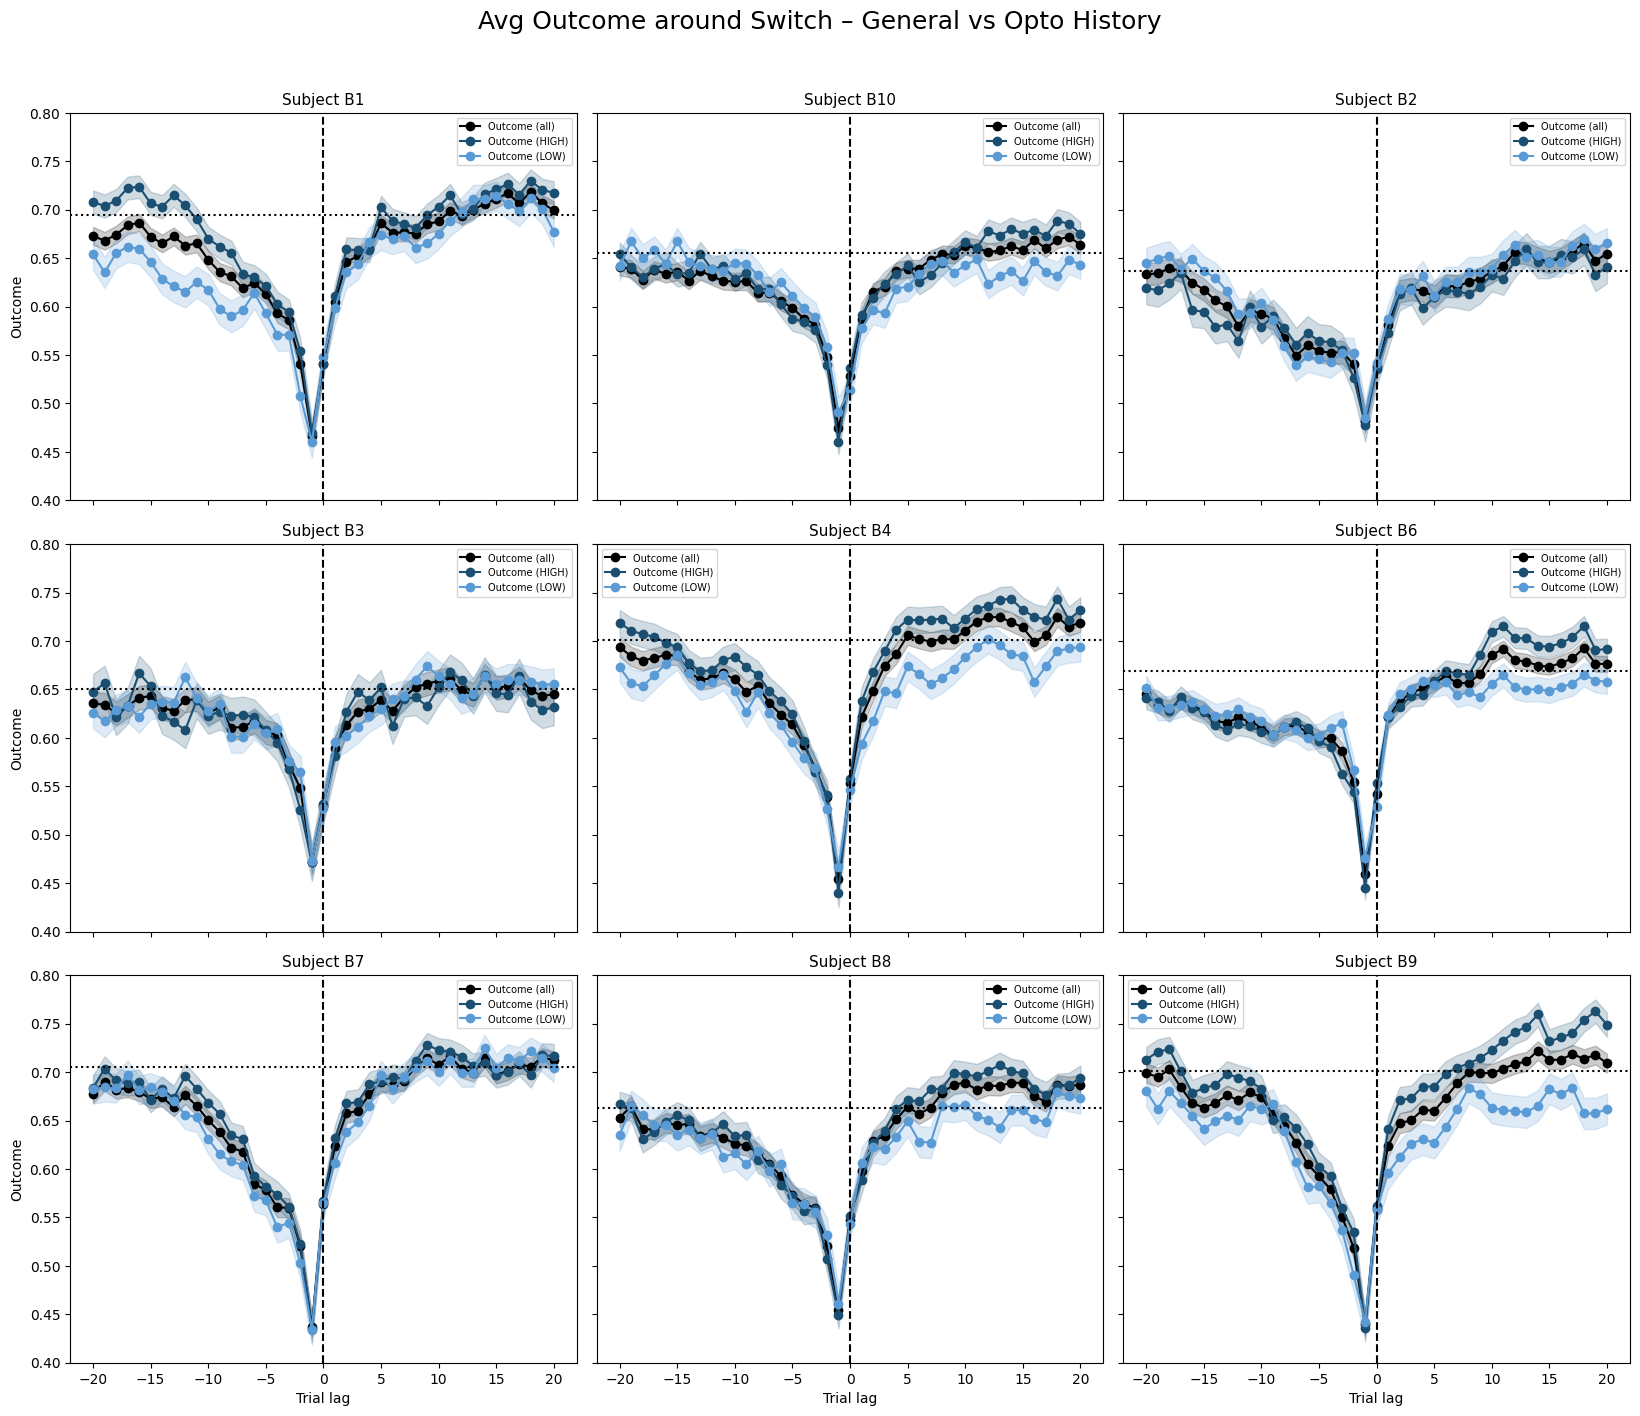

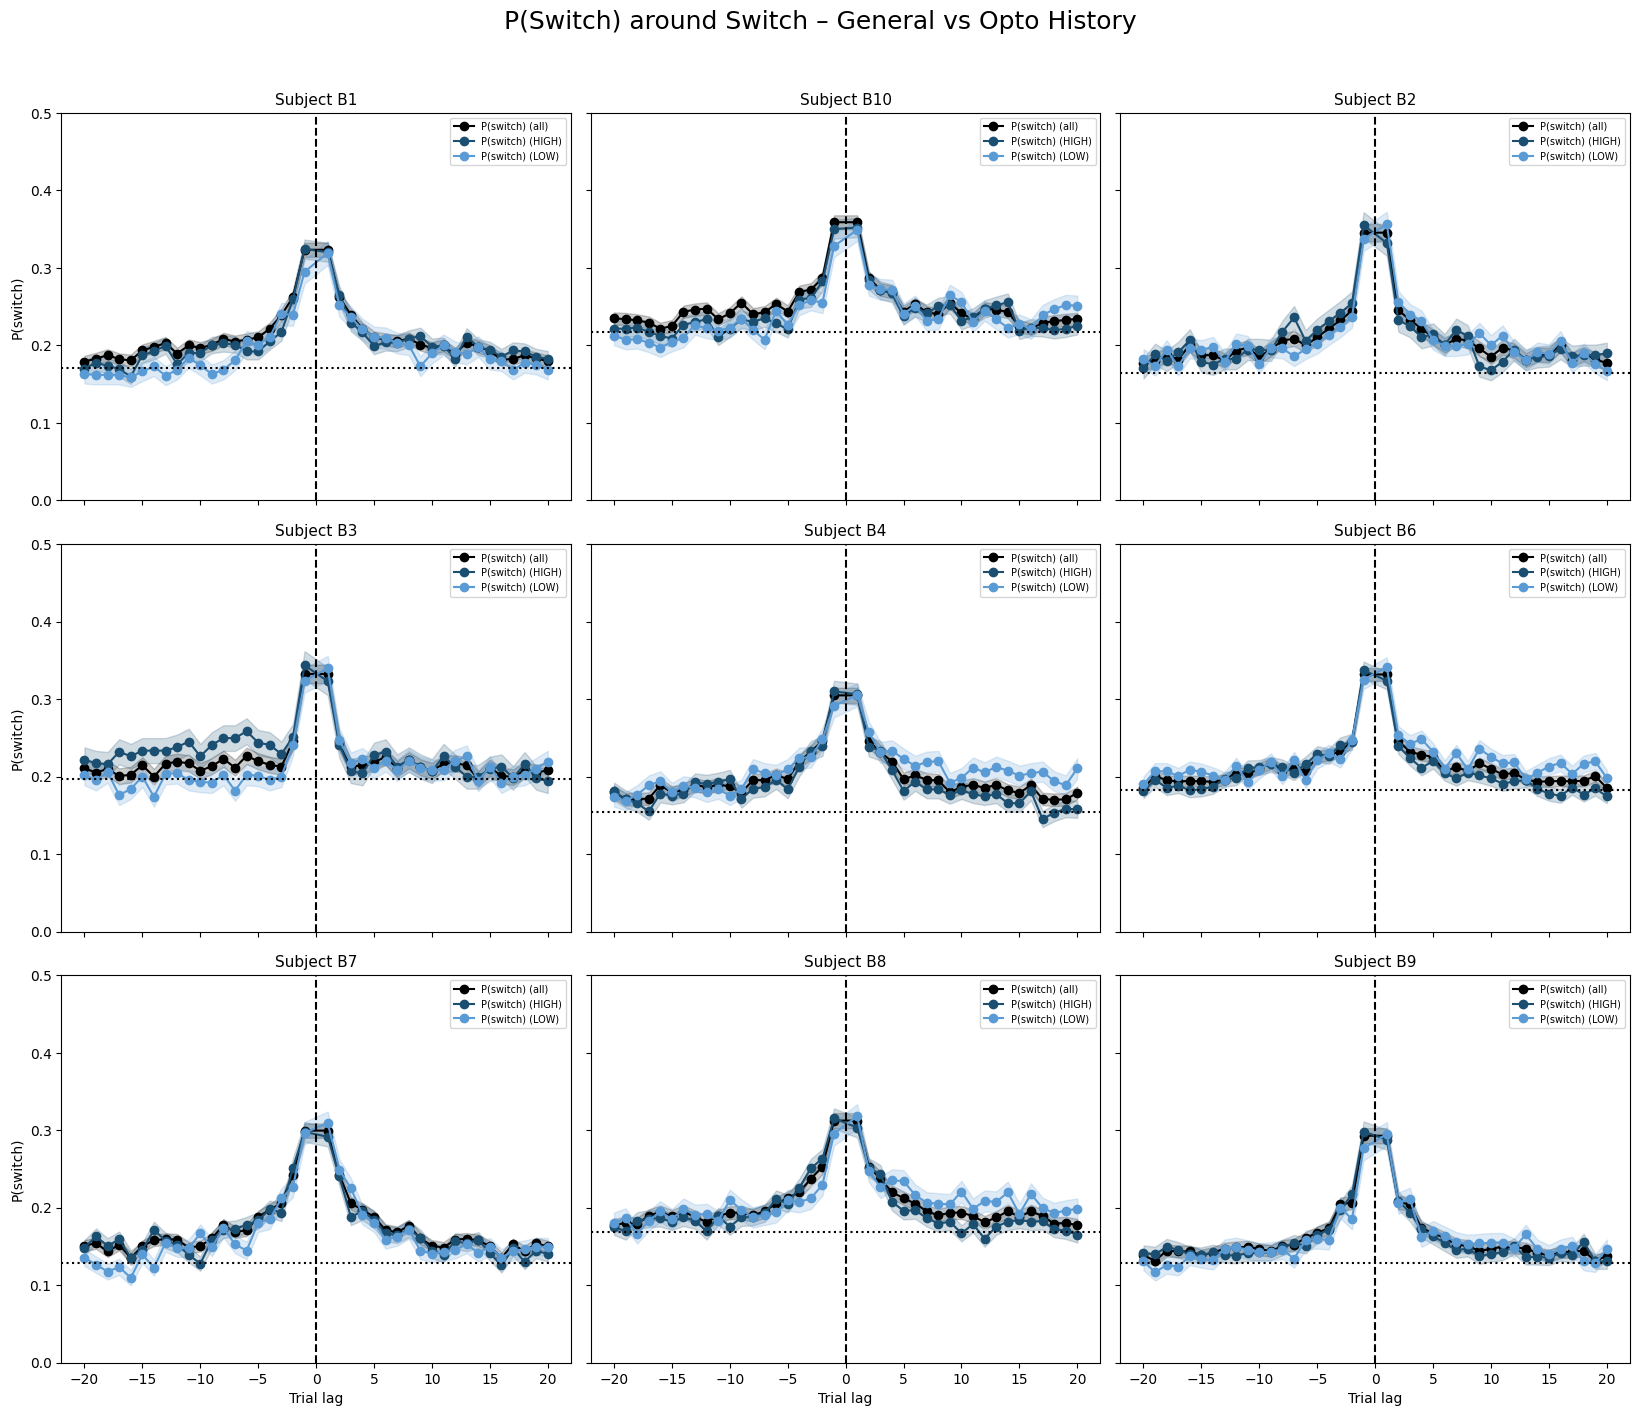

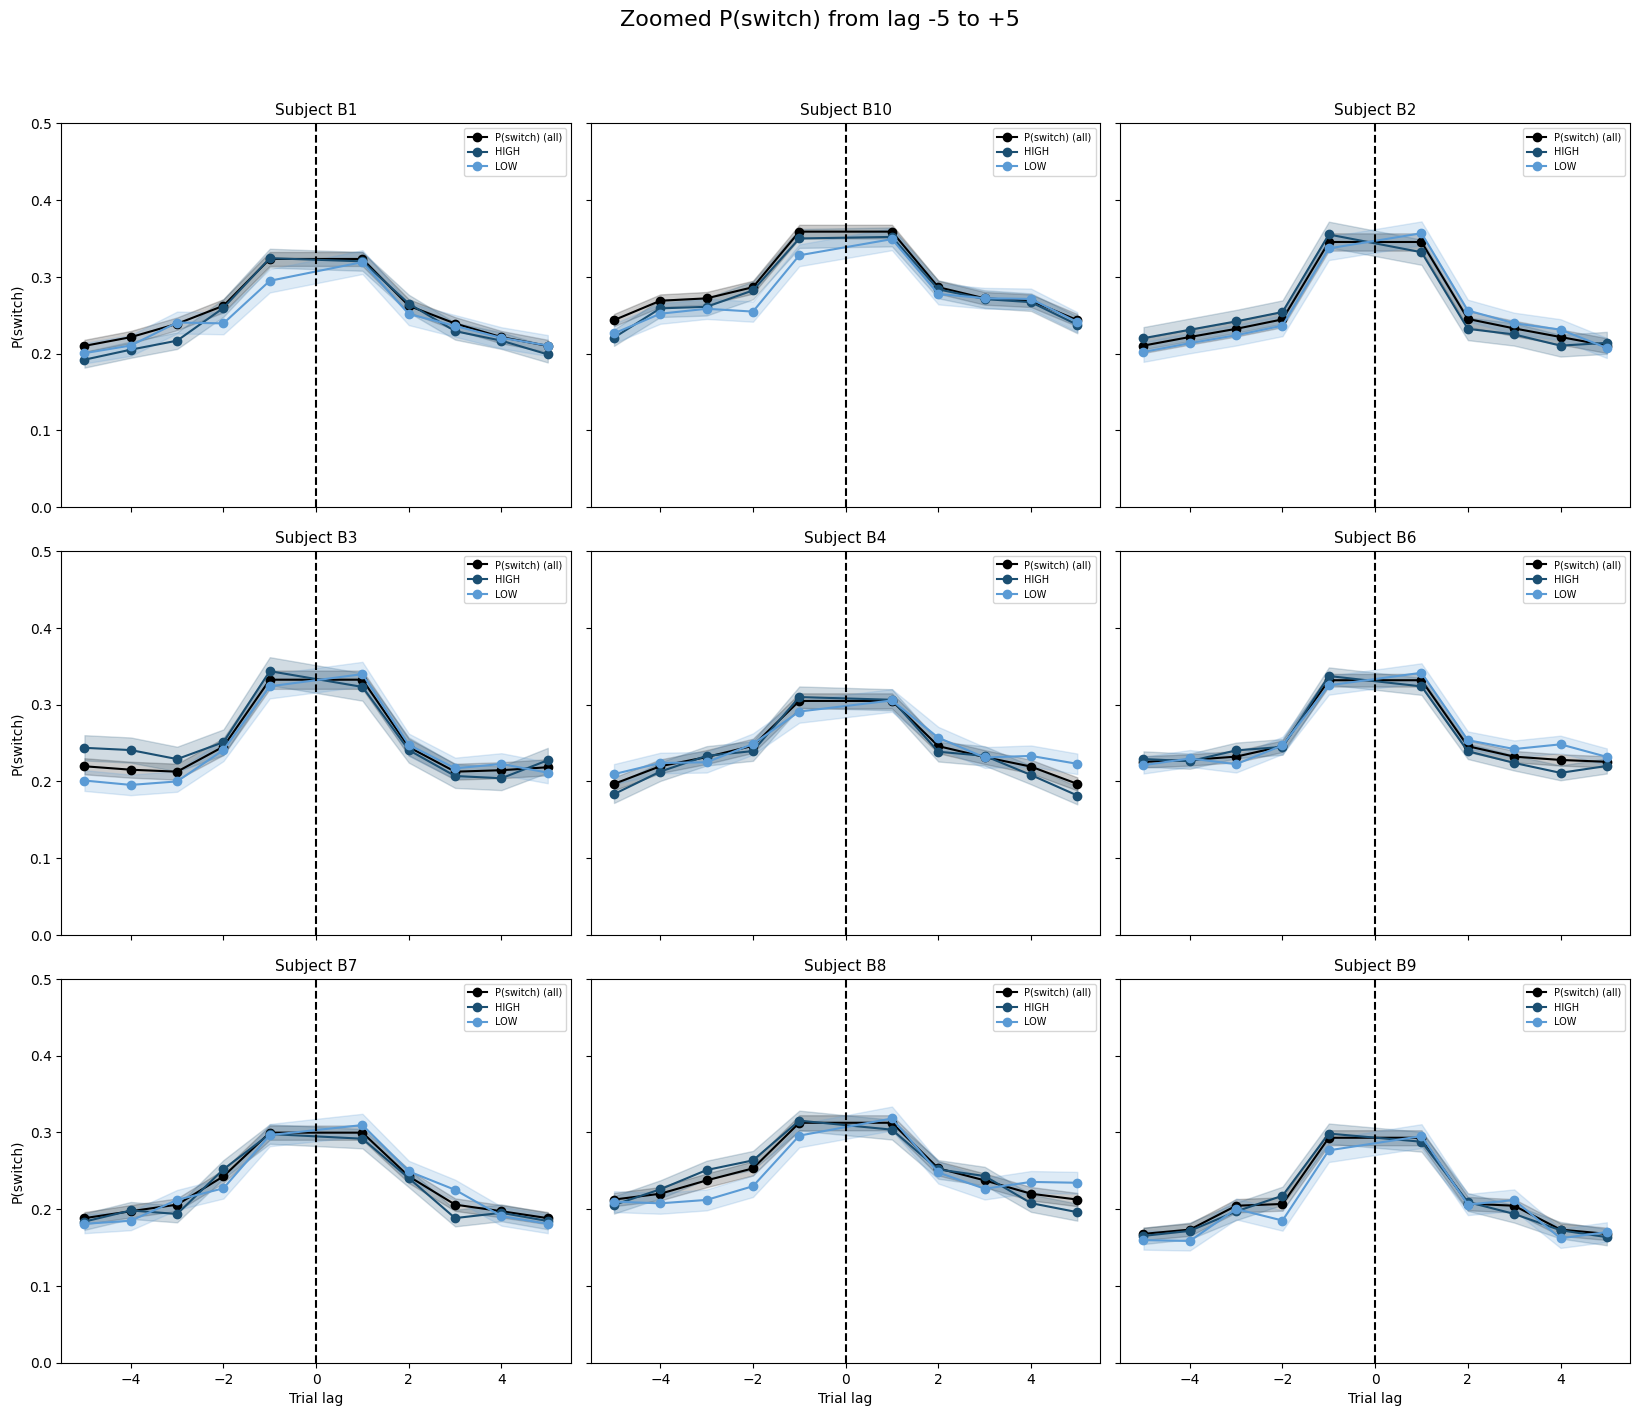

In [35]:
def plot_outcome_and_switch_lag_analysis_with_opto_v2(df1, window=20, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig_outcome, axs_outcome = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    fig_switch, axs_switch = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs_outcome = axs_outcome.flatten()
    axs_switch = axs_switch.flatten()

    # Colori uniformi
    high_color = '#1b4f72'    # blu intenso
    low_color = '#5b9bd5'    # blu desaturato

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        global_switch_mean = subj_df['switch_num'].mean()

        data = {
            'general_outcome': [],
            'general_switch': [],
            'high_outcome': [],
            'high_switch': [],
            'low_outcome': [],
            'low_switch': []
        }

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values
            opto_vals = subj_df.iloc[idx - window:idx]['prev_opto_bool'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                data['general_outcome'].append({'lag': lag, 'value': o})
                data['general_switch'].append({'lag': lag, 'value': s})

            opto_sum = np.sum(opto_vals)
            if opto_sum >= 4:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['high_outcome'].append({'lag': lag, 'value': o})
                    data['high_switch'].append({'lag': lag, 'value': s})
            elif opto_sum <= 3:
                for lag, o, s in zip(lags, outcome_vals, switch_vals):
                    data['low_outcome'].append({'lag': lag, 'value': o})
                    data['low_switch'].append({'lag': lag, 'value': s})

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        def plot_errorbar(ax, df, label, color, marker, linestyle):
            if not df.empty:
                mean, sem = mean_sem(df)
                ax.plot(mean.index, mean.values, marker=marker, linestyle=linestyle, color=color, label=label)
                ax.fill_between(mean.index, mean.values - sem, mean.values + sem,
                                color=color, alpha=0.2)
        # OUTCOME PLOT
        ax_out = axs_outcome[i]
        plot_errorbar(ax_out, pd.DataFrame(data['general_outcome']), 'Outcome (all)', 'black', 'o', '-')
        plot_errorbar(ax_out, pd.DataFrame(data['high_outcome']), 'Outcome (HIGH)', high_color, 'o', '-')
        plot_errorbar(ax_out, pd.DataFrame(data['low_outcome']), 'Outcome (LOW)', low_color, 'o', '-')
        ax_out.axvline(0, linestyle='--', color='black')
        ax_out.axhline(subject_mean, linestyle=':', color='black')
        ax_out.set_title(f'Subject {subj}', fontsize=11)
        ax_out.set_ylim(0.4, 0.8)
        if i % ncols == 0:
            ax_out.set_ylabel('Outcome')
        if i >= (nrows - 1) * ncols:
            ax_out.set_xlabel('Trial lag')
        ax_out.legend(fontsize=7)

        # SWITCH PLOT
        ax_sw = axs_switch[i]
        plot_errorbar(ax_sw, pd.DataFrame(data['general_switch']).query('lag != 0'), 'P(switch) (all)', 'black', 'o', '-')
        plot_errorbar(ax_sw, pd.DataFrame(data['high_switch']).query('lag != 0'), 'P(switch) (HIGH)', high_color, 'o', '-')
        plot_errorbar(ax_sw, pd.DataFrame(data['low_switch']).query('lag != 0'), 'P(switch) (LOW)', low_color, 'o', '-')
        ax_sw.axvline(0, linestyle='--', color='black')
        ax_sw.axhline(global_switch_mean, linestyle=':', color='black')
        ax_sw.set_title(f'Subject {subj}', fontsize=11)
        ax_sw.set_ylim(0, 0.5)
        if i % ncols == 0:
            ax_sw.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax_sw.set_xlabel('Trial lag')
        ax_sw.legend(fontsize=7)

    for j in range(n, len(axs_outcome)):
        fig_outcome.delaxes(axs_outcome[j])
        fig_switch.delaxes(axs_switch[j])

    fig_outcome.suptitle('Avg Outcome around Switch – General vs Opto History', fontsize=18)
    fig_switch.suptitle('P(Switch) around Switch – General vs Opto History', fontsize=18)
    fig_outcome.tight_layout(rect=[0, 0, 1, 0.96])
    fig_switch.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_switch_lag_zoom(df1, window=20, max_subjects=9, lag_window=5):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    ncols = 3
    nrows = (len(subjects) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    high_color = '#1b4f72'
    low_color = '#5b9bd5'

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)

        data = {
            'general_switch': [],
            'high_switch': [],
            'low_switch': []
        }

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue
            lags = np.arange(-window, window + 1)
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values
            opto_vals = subj_df.iloc[idx - window:idx]['prev_opto_bool'].values

            for lag, s in zip(lags, switch_vals):
                if abs(lag) <= lag_window:
                    data['general_switch'].append({'lag': lag, 'value': s})

            opto_sum = np.sum(opto_vals)
            if opto_sum >= 4:
                for lag, s in zip(lags, switch_vals):
                    if abs(lag) <= lag_window:
                        data['high_switch'].append({'lag': lag, 'value': s})
            elif opto_sum <= 3:
                for lag, s in zip(lags, switch_vals):
                    if abs(lag) <= lag_window:
                        data['low_switch'].append({'lag': lag, 'value': s})

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        def plot_area(ax, df, label, color, linestyle, marker='x'):
            if not df.empty:
                mean, sem = mean_sem(df)
                ax.plot(mean.index, mean.values, linestyle=linestyle, color=color, label=label,  marker=marker)
                ax.fill_between(mean.index, mean.values - sem, mean.values + sem, color=color, alpha=0.2)

        ax = axs[i]
        plot_area(ax, pd.DataFrame(data['general_switch']).query('lag != 0'), 'P(switch) (all)', 'black', '-', marker='o')
        plot_area(ax, pd.DataFrame(data['high_switch']).query('lag != 0'), 'HIGH', high_color, '-',  marker='o')
        plot_area(ax, pd.DataFrame(data['low_switch']).query('lag != 0'), 'LOW', low_color, '-',  marker='o')

        ax.axvline(0, linestyle='--', color='black')
        ax.set_title(f'Subject {subj}', fontsize=11)
        ax.set_ylim(0, 0.5)
        if i % ncols == 0:
            ax.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel('Trial lag')
        ax.legend(fontsize=7)

    for j in range(len(subjects), len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'Zoomed P(switch) from lag -{lag_window} to +{lag_window}', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_outcome_and_switch_lag_analysis_with_opto_v2(new_df1, window=20)
plot_switch_lag_zoom(new_df1, window=20, max_subjects=9, lag_window=5)

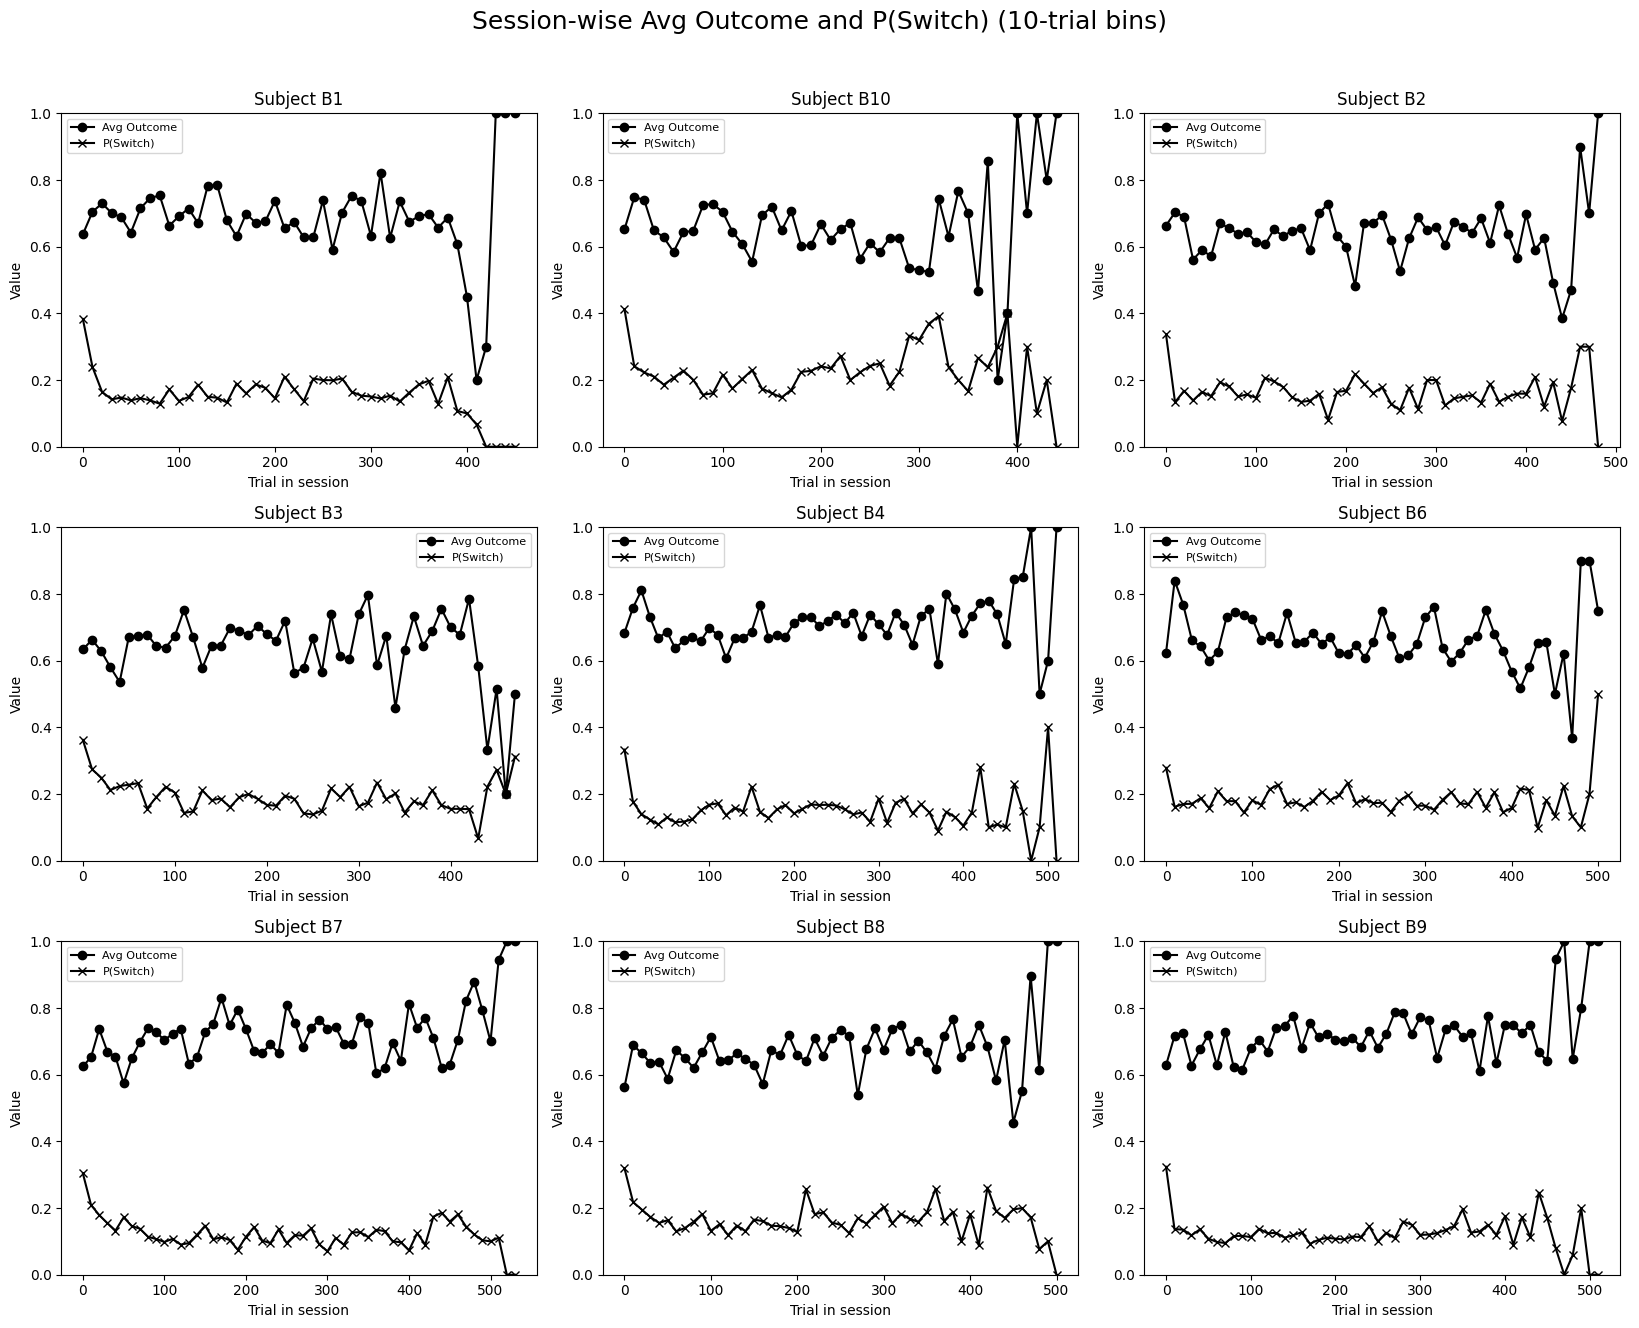

In [ ]:
# Re-import necessary modules due to code execution reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Re-define get_switch_indices function
def get_switch_indices(df):
    return df.index[df['switch_num'] == 1].tolist()

# Redefine the full plotting functions after reset
def plot_outcome_and_switch_lag_analysis(df1, window=20, max_subjects=9):
    subjects = sorted(df1['subject'].unique())[:max_subjects]
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig_outcome, axs_outcome = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    fig_switch, axs_switch = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.8 * nrows), sharex=True, sharey=True)
    axs_outcome = axs_outcome.flatten()
    axs_switch = axs_switch.flatten()

    for i, subj in enumerate(subjects):
        subj_df = df1[df1['subject'] == subj].reset_index(drop=True)
        switch_idx = get_switch_indices(subj_df)
        subject_mean = subj_df['fraction_of_correct_responses'].mean()
        global_switch_mean = subj_df['switch_num'].mean()

        aligned_outcome = []
        aligned_switch = []

        for idx in switch_idx:
            if idx - window < 0 or idx + window >= len(subj_df):
                continue

            lags = np.arange(-window, window + 1)
            outcome_vals = subj_df.iloc[idx - window:idx + window + 1]['fraction_of_correct_responses'].values
            switch_vals = subj_df.iloc[idx - window:idx + window + 1]['switch_num'].values

            for lag, o, s in zip(lags, outcome_vals, switch_vals):
                aligned_outcome.append({'lag': lag, 'value': o})
                aligned_switch.append({'lag': lag, 'value': s})

        outcome_df = pd.DataFrame(aligned_outcome)
        switch_df = pd.DataFrame(aligned_switch)
        switch_df = switch_df[switch_df['lag'] != 0]  # remove lag=0

        def mean_sem(df):
            return df.groupby('lag')['value'].mean(), df.groupby('lag')['value'].sem()

        # Plot outcome
        ax_out = axs_outcome[i]
        if not outcome_df.empty:
            mean, sem = mean_sem(outcome_df)
            ax_out.errorbar(mean.index, mean.values, yerr=sem.values, fmt='o-', capsize=3, color='black')
        ax_out.axvline(0, linestyle='--', color='black')
        ax_out.axhline(subject_mean, linestyle=':', color='green')
        ax_out.set_title(f'Subject {subj}', fontsize=11)
        ax_out.set_ylim(0, 1.05)
        if i % ncols == 0:
            ax_out.set_ylabel('Outcome')
        if i >= (nrows - 1) * ncols:
            ax_out.set_xlabel('Trial lag')

        # Plot switch
        ax_sw = axs_switch[i]
        if not switch_df.empty:
            mean_s, sem_s = mean_sem(switch_df)
            ax_sw.errorbar(mean_s.index, mean_s.values, yerr=sem_s.values, fmt='x-', capsize=3, color='orange')
        ax_sw.axvline(0, linestyle='--', color='black')
        ax_sw.axhline(global_switch_mean, linestyle=':', color='orange')
        ax_sw.set_title(f'Subject {subj}', fontsize=11)
        ax_sw.set_ylim(0, 1)
        if i % ncols == 0:
            ax_sw.set_ylabel('P(switch)')
        if i >= (nrows - 1) * ncols:
            ax_sw.set_xlabel('Trial lag')

    for j in range(n, len(axs_outcome)):
        fig_outcome.delaxes(axs_outcome[j])
        fig_switch.delaxes(axs_switch[j])

    fig_outcome.suptitle('Avg Outcome around Switch (Extended Lag)', fontsize=18)
    fig_switch.suptitle('P(Switch) around Switch (Lag≠0)', fontsize=18)
    fig_outcome.tight_layout(rect=[0, 0, 1, 0.96])
    fig_switch.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_sessionwise_binned_outcome_and_switch(df1, bin_size=10):
    df1 = df1.copy()
    df1['trial_bin'] = (df1['trial'] // bin_size) * bin_size

    grouped = df1.groupby(['subject', 'trial_bin'])
    outcome_mean = grouped['fraction_of_correct_responses'].mean().reset_index()
    switch_mean = grouped['switch_num'].mean().reset_index()

    subjects = sorted(df1['subject'].unique())
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.5 * nrows), sharex=False)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_out = outcome_mean[outcome_mean['subject'] == subj]
        subj_sw = switch_mean[switch_mean['subject'] == subj]

        ax.plot(subj_out['trial_bin'], subj_out['fraction_of_correct_responses'], label='Avg Outcome', color='black', marker='o')
        ax.plot(subj_sw['trial_bin'], subj_sw['switch_num'], label='P(Switch)', color='black', marker='x')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1)
        ax.set_xlabel('Trial in session')
        ax.set_ylabel('Value')
        ax.legend(fontsize=8)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle('Session-wise Avg Outcome and P(Switch) (10-trial bins)', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_sessionwise_binned_outcome_and_switch(new_df1, bin_size=10)

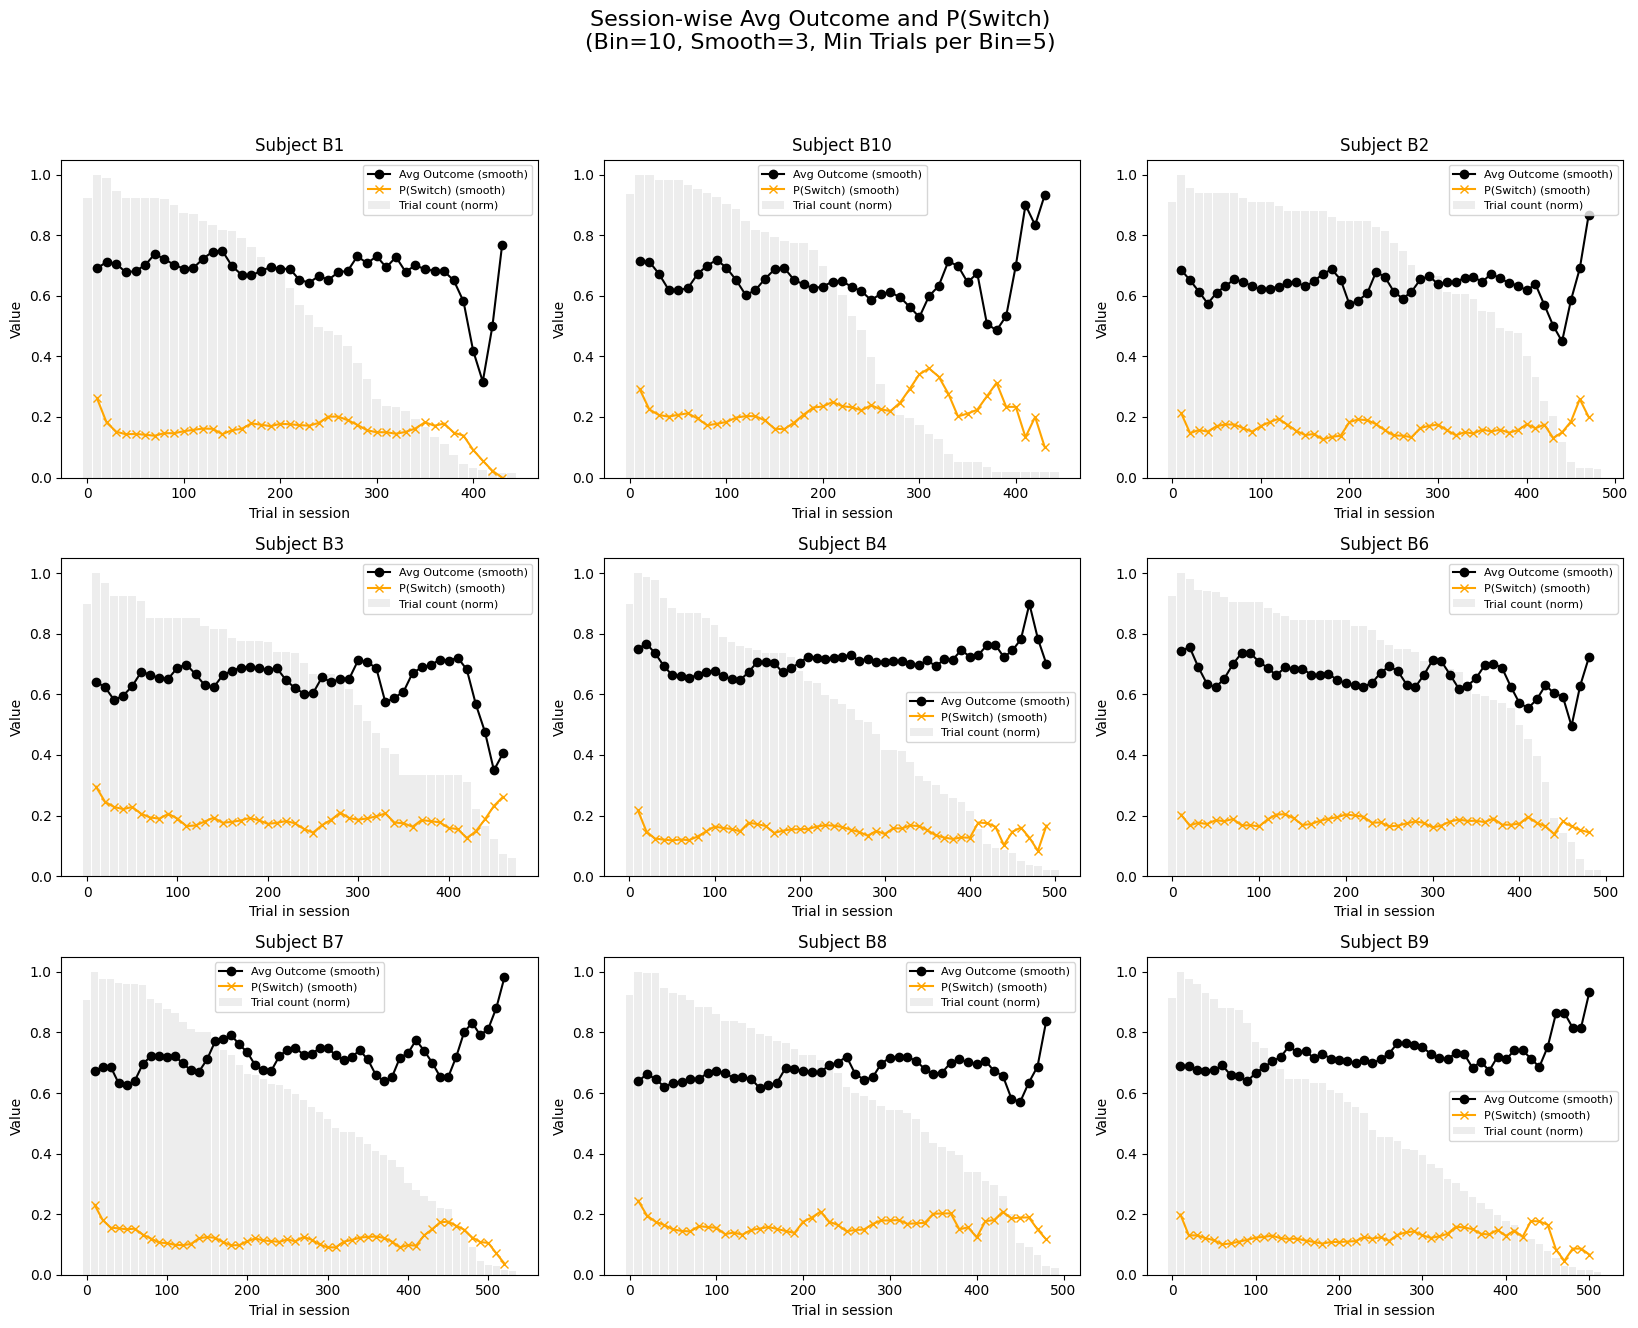

In [ ]:
def plot_sessionwise_binned_outcome_and_switch(df1, bin_size=10, min_trials_per_bin=5, smooth_window=3):
    df1 = df1.copy()
    df1['trial_bin'] = (df1['trial'] // bin_size) * bin_size

    # Conta il numero di trial per bin
    bin_counts = df1.groupby(['subject', 'trial_bin']).size().reset_index(name='n_trials')

    # Calcola media degli outcome e degli switch
    grouped = df1.groupby(['subject', 'trial_bin'])
    outcome_mean = grouped['fraction_of_correct_responses'].mean().reset_index()
    switch_mean = grouped['switch_num'].mean().reset_index()

    # Merge per avere il numero di trial
    merged = pd.merge(outcome_mean, switch_mean, on=['subject', 'trial_bin'])
    merged = pd.merge(merged, bin_counts, on=['subject', 'trial_bin'])

    # Filtra via i bin con meno di n trial
    merged = merged[merged['n_trials'] >= min_trials_per_bin]

    subjects = sorted(df1['subject'].unique())
    n = len(subjects)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.5 * nrows), sharex=False)
    axs = axs.flatten()

    for i, subj in enumerate(subjects):
        ax = axs[i]
        subj_data = merged[merged['subject'] == subj]

        if subj_data.empty:
            continue

        # Normalize trial count to [0,1] for transparency
        max_count = subj_data['n_trials'].max()
        bar_heights = subj_data['n_trials'] / max_count  # normalized

        # Smoothing con media mobile
        smoothed_outcome = subj_data['fraction_of_correct_responses'].rolling(smooth_window, center=True).mean()
        smoothed_switch = subj_data['switch_num'].rolling(smooth_window, center=True).mean()

        # Plot barre trasparenti (sfondo)
        ax.bar(subj_data['trial_bin'], bar_heights, width=bin_size * 0.9, color='lightgray', alpha=0.4, label='Trial count (norm)')

        # Plot linee smoothed
        ax.plot(subj_data['trial_bin'], smoothed_outcome, label='Avg Outcome (smooth)', color='black', marker='o')
        ax.plot(subj_data['trial_bin'], smoothed_switch, label='P(Switch) (smooth)', color='orange', marker='x')

        ax.set_title(f'Subject {subj}')
        ax.set_ylim(0, 1.05)
        ax.set_xlabel('Trial in session')
        ax.set_ylabel('Value')
        ax.legend(fontsize=8)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle(f'Session-wise Avg Outcome and P(Switch)\n(Bin={bin_size}, Smooth={smooth_window}, Min Trials per Bin={min_trials_per_bin})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
plot_sessionwise_binned_outcome_and_switch(new_df1, bin_size=10, min_trials_per_bin=5, smooth_window=3)
